In [1]:
# =============================================================================
# 外匯策略實證研究：基於經濟基本面的投資組合配置
# Foreign Exchange Strategy Research: Portfolio Allocation Based on Economic Fundamentals
# =============================================================================

import pandas as pd
import numpy as np

In [2]:
# 統計分析套件
from scipy import stats
import statsmodels.api as sm

In [3]:
# 視覺化套件
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [4]:
# =============================================================================
# 輔助函數定義
# =============================================================================

def create_seg(max_value):
    rank_count = int(max_value)
    quotient = int(rank_count // 5)
    remainder = int(rank_count % 5)
    seg = [i for i in range(quotient+1, (quotient+1) * 5, quotient+1)]
    if remainder == 0:
        seg = list(range(quotient,rank_count,quotient))
        return seg
    elif remainder == 4:
        seg[2] -= 1
        seg[3] -= 1
    elif remainder == 3:
        seg[1] -= 1
        seg[2] -= 1
        seg[3] -= 2
    elif remainder == 2:
        seg[1] -= 1
        seg[2] -= 2
        seg[3] -= 3
    elif remainder == 1:
        seg[0] -= 1
        seg[1] -= 2
        seg[2] -= 2
        seg[3] -= 3
    return seg
# 定義一個函數將排名拆成五等分
def map_rank_to_group(value, max_value):
    # 获取列的最大值
    seg = create_seg(max_value)
    if np.isnan(value):
        pass
    elif value <= seg[0]:
        return 1
    elif seg[0] < value <= seg[1]:
        return 2
    elif seg[1] < value <= seg[2]:
        return 3
    elif seg[2] < value <= seg[3]:
        return 4
    else:
        return 5


# 第一部分：數據載入與處理

## 1.1 經濟數據與匯率數據載入

In [5]:
# 載入經濟數據
CAB = pd.read_excel('Economic Data/current account balance.xlsx', sheet_name='工作表2')  # 經常帳餘額
GDP = pd.read_excel('Economic Data/GDP.xlsx', sheet_name='工作表2')                    # 國內生產毛額
IMP = pd.read_excel('Economic Data/imports.xlsx', sheet_name='工作表2')               # 進口
INR = pd.read_excel('Economic Data/international reserve.xlsx', sheet_name='工作表2')  # 國際準備
NFA = pd.read_excel('Economic Data/net foreign assets.xlsx', sheet_name='工作表2')     # 淨國外資產

# 整合經濟數據字典
ECO = {
    'current_account_balance': CAB, 
    'GDP': GDP, 
    'imports': IMP, 
    'international_reserve': INR, 
    'net_foreign_assets': NFA
}

# 定義研究國家清單
countries = (
    'Australia', 'Brazil', 'Canada', 'Czech Republic', 'Denmark', 'Hungary', 
    'Japan', 'Mexico', 'New Zealand', 'Norway', 'Poland', 'Singapore', 
    'South Africa', 'Korea', 'Sweden', 'Switzerland', 'Taiwan', 'Turkey', 
    'United Kingdom', 'Euro Area'
)

# 載入匯率數據
FX = pd.read_excel('exchage_rate.xlsx', index_col=0)  # 即期匯率
FX.index = pd.to_datetime(FX.index)
FX = FX.rename_axis('Date', axis='index')

FX_FW = pd.read_excel('exchange_forward6M.xlsx', index_col=0)  # 6個月遠期匯率
FX_FW.index = pd.to_datetime(FX_FW.index)
FX_FW = FX_FW.rename_axis('Date', axis='index')

FX_FW_3M = pd.read_excel('exchange_forward3M.xlsx', index_col=0)  # 3個月遠期匯率
FX_FW_3M.index = pd.to_datetime(FX_FW_3M.index)
FX_FW_3M = FX_FW_3M.rename_axis('Date', axis='index')

# 處理經濟資料格式
for key, df in ECO.items():
    # 移除不需要的列
    df = df.drop(df.columns[[0, 1]], axis=1)
    # 設置國家名稱為索引
    df['Name'] = countries
    df.set_index('Name', inplace=True)
    ECO[key] = df

In [6]:
## 1.2 匯率數據處理與貨幣方向調整

# 建立貨幣代碼對應表
Cur = {}
for i in range(len(ECO['GDP'])):
    Cur[ECO['GDP']['CURRENCY'][i]] = ECO['GDP'].index[i]

# 選擇中間價列（每三列取一列，從第2列開始）
start = 2
step = 3
end = len(FX.columns)
selected_columns = list(range(start - 1, end, step))  # 列索引從0開始，因此減1

# 定義匯率方向調整函數
# 注意：部分貨幣方向錯誤，需要取倒數進行調整
def inverse_if_condition_fixed(column):
    """
    調整匯率方向：USD開頭的貨幣保持原樣，其他貨幣取倒數
    """
    if column.name.startswith('US'):
        return column
    else:
        # 轉換為浮點數後取倒數，避免整數除法問題
        return column.apply(lambda x: np.nan if pd.isna(x) else 1.0 / float(x))
# 應用匯率方向調整並創建中間價DataFrames
Mid_FX = FX.iloc[:, selected_columns].apply(inverse_if_condition_fixed)
Mid_FX.columns = countries

Mid_FX_FW = FX_FW.iloc[:, selected_columns].apply(inverse_if_condition_fixed)
Mid_FX_FW.columns = countries

Mid_FX_FW_3M = FX_FW_3M.iloc[:, selected_columns].apply(inverse_if_condition_fixed)
Mid_FX_FW_3M.columns = countries

# 提取季度末數據（3月、6月、9月、12月）
last_days = Mid_FX.groupby(Mid_FX.index.to_period('M')).tail(1)
selected_months = last_days[last_days.index.month.isin([3, 6, 9, 12])]

# 建立季度匯率數據
Mid_FX_Q = Mid_FX.loc[selected_months.index]
Mid_FX_FW_Q = Mid_FX_FW.loc[selected_months.index]
Mid_FX_Q_3M = Mid_FX_FW_3M.loc[selected_months.index]
Mid_FX_FW_Q_3M = Mid_FX_FW_3M.loc[selected_months.index]

# 建立季度與日期的對照表
selected_columns = ['CURRENCY'] + list(Mid_FX_Q.index)
Q2dt_dict = {
    ECO['GDP'].columns[:][::-1][i]: Mid_FX_Q.index[i] for i in range(len(Mid_FX_Q))
}

# 調整經濟數據的列名為日期格式
for key, df in ECO.items():
    df = df.rename(columns=Q2dt_dict).drop('Q2 2024', axis=1, errors='ignore')
    ECO[key] = df[selected_columns]

# 將所有經濟數據統一轉換為美元計價
for key, df in ECO.items():
    temp_df = df.copy()
    for country in df.index:
        if df.loc[country, 'CURRENCY'] != 'U$':
            currency = Cur[df.loc[country, 'CURRENCY']]
            for dt in list(Mid_FX_Q.index):
                temp_df.loc[country, dt] = float(df.loc[country, dt] * Mid_FX.loc[dt, currency])
    temp_df.drop('CURRENCY', axis=1, inplace=True)
    ECO[key] = temp_df

In [7]:
## 1.3 計算經濟變數比例

# 計算各項經濟指標的相對比例
Cab = ECO['current_account_balance'] / ECO['GDP']          # 經常帳餘額/GDP比例
Inr = ECO['international_reserve'] / ECO['GDP']           # 國際準備/GDP比例
Nfa = ECO['net_foreign_assets'] / ECO['imports']          # 淨國外資產/進口比例

# 整合處理後的經濟變數
Eco = {}
Eco['current_account_balance'] = Cab
Eco['international_reserve'] = Inr
Eco['net_foreign_assets'] = Nfa

In [8]:
Eco['net_foreign_assets']

,1999-06-30,1999-09-30,1999-12-31,2000-03-31,2000-06-30,2000-09-29,2000-12-29,2001-03-30,2001-06-29,2001-09-28,...,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-30,2023-03-31,2023-06-30,2023-09-29,2023-12-29,2024-03-29
Name,,,,,,,,,,,,,,,,,,,,,
Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.748420,0.688465,0.661001,0.637023,0.675178,0.741541,0.752842,0.721591,0.725104,NaN
Brazil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.093974,3.585426,3.619514,3.114887,3.288003,3.768819,3.698902,3.816982,3.806922,NaN
Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.032431,0.100711,0.129432,0.129324,0.131741,0.112071,0.116968,0.141078,0.098169,NaN
Czech Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.571811,1.540801,1.615578,...,2.997104,2.942140,2.455023,2.207760,2.048247,2.195869,2.306153,2.453553,2.412850,NaN
Denmark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.288096,1.276419,1.147444,1.162432,1.207448,1.413326,1.396032,1.344547,1.321606,NaN
Hungary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.494316,0.608021,0.676058,...,0.705958,0.624803,0.644342,0.632054,0.517432,0.591150,0.600263,0.747735,0.774812,NaN
Japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.609844,-0.495160,-0.461672,-0.569009,-0.666507,-0.455406,-0.684039,-0.710122,-0.825591,NaN
Mexico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.254349,1.241985,1.103990,1.049640,1.108469,1.115183,1.099552,1.151508,NaN,NaN
New Zealand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.563693,0.584233,0.537485,0.547198,0.500725,0.499080,0.401482,0.590007,0.554655,NaN


In [9]:
## 1.4 載入CPI數據

# 載入消費者物價指數數據
cpi = pd.read_excel('新增經濟資料/CPI.xlsx', skiprows=3, sheet_name='工作表3')

In [10]:
# 處理CPI數據格式
ECO_2 = {'cpi': cpi}
for key, df in ECO_2.items():
    # 設置國家名稱為索引
    df['Name'] = countries
    df.set_index('Name', inplace=True)
    ECO_2[key] = df

In [11]:
# 處理ECO_2 column names，將其轉換成日期格式
# 先製作一個對照表
for key,df in ECO_2.items():
    df = df.rename(columns=Q2dt_dict).drop('Q2 2024', axis=1, errors='ignore')
    ECO_2[key] = df[selected_columns[4:]] #.drop(columns='CURRENCY')

In [12]:
Eco['cpi'] = ECO_2['cpi']

In [13]:
# 將時間限定在2002Q1 - 2022Q4之間
for key,df in Eco.items():
    if key == 'cpi':
        Eco[key] = df.iloc[:,8:-3]
    else:
        Eco[key] = df.iloc[:,11:-3]

In [14]:
for key,df in Eco.items():
    print(df.columns[:3],df.columns[-3:])

Index([2002-03-29 00:00:00, 2002-06-28 00:00:00, 2002-09-30 00:00:00], dtype='object') Index([2022-12-30 00:00:00, 2023-03-31 00:00:00, 2023-06-30 00:00:00], dtype='object')
Index([2002-03-29 00:00:00, 2002-06-28 00:00:00, 2002-09-30 00:00:00], dtype='object') Index([2022-12-30 00:00:00, 2023-03-31 00:00:00, 2023-06-30 00:00:00], dtype='object')
Index([2002-03-29 00:00:00, 2002-06-28 00:00:00, 2002-09-30 00:00:00], dtype='object') Index([2022-12-30 00:00:00, 2023-03-31 00:00:00, 2023-06-30 00:00:00], dtype='object')
Index([2002-03-29 00:00:00, 2002-06-28 00:00:00, 2002-09-30 00:00:00], dtype='object') Index([2022-12-30 00:00:00, 2023-03-31 00:00:00, 2023-06-30 00:00:00], dtype='object')


In [15]:
Eco_rank = {}
for key,df in Eco.items():
    rank = df.rank(axis=0, method='min', ascending=False)
    Eco_rank[key+'_ranked'] = rank

In [16]:
## 1.5 經濟變數排名計算（排除缺失值）

# 針對每個時期，僅對有完整數據的國家進行排名
Eco_rank_exclude_nan = {f'{i}_ranked': pd.DataFrame() for i in Eco.keys()}

for colname in Eco['cpi'].columns:
    # 找出該時期有完整數據的國家
    idx = set(Eco['current_account_balance'].index)
    for _, df in Eco.items():
        idx = idx.intersection(df[colname].dropna().index)
    idx = list(idx)
    
    # 對每個經濟變數進行排名
    for key in Eco.keys():
        if key == 'cpi':
            # CPI採用升序排名（數值越小越好）
            ranking = Eco[key].loc[idx, colname].rank(axis=0, method='min', ascending=True)
        else:
            # 其他經濟變數採用降序排名（數值越大越好）
            ranking = Eco[key].loc[idx, colname].rank(axis=0, method='min', ascending=False)
        
        # 將排名結果存入對應的DataFrame
        for id in idx:
            Eco_rank_exclude_nan[f'{key}_ranked'].at[id, colname] = ranking[id]
        Eco_rank_exclude_nan[f'{key}_ranked'] = Eco_rank_exclude_nan[f'{key}_ranked'].reindex(index=countries)

# 第二部分：國家脆弱性綜合排名

## 2.1 計算綜合脆弱性指標


## short-term external debt as a percent of foreign exchange reserves
## gross government debt as a percent of GDP
## average annual inflation over the past three years

In [17]:
# 建立總體排名DataFrame用於存儲綜合脆弱性指標
dates = Eco_rank_exclude_nan['cpi_ranked'].columns
total_rank_df = pd.DataFrame(None, index=Eco_rank_exclude_nan['current_account_balance_ranked'].index, columns=dates)

In [18]:
# 計算每個國家的綜合脆弱性排名（四個經濟變數排名的簡單加總）
for col in total_rank_df.columns:
    country_set = total_rank_df.index
    for idx in country_set:
        total_rank_df.at[idx, col] = (
            Eco_rank_exclude_nan['current_account_balance_ranked'].loc[idx, col] +
            Eco_rank_exclude_nan['international_reserve_ranked'].loc[idx, col] +
            Eco_rank_exclude_nan['net_foreign_assets_ranked'].loc[idx, col] +
            Eco_rank_exclude_nan['cpi_ranked'].loc[idx, col]
        )

In [19]:
Eco_rank_exclude_nan['cpi_ranked']

,2002-03-29,2002-06-28,2002-09-30,2002-12-31,2003-03-31,2003-06-30,2003-09-30,2003-12-31,2004-03-31,2004-06-30,...,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-30,2023-03-31,2023-06-30
Australia,12.0,12.0,12.0,12.0,12.0,12.0,12.0,11.0,12.0,12.0,...,9.0,10.0,10.0,10.0,10.0,9.0,8.0,7.0,6.0,8.0
Brazil,13.0,13.0,13.0,14.0,15.0,15.0,15.0,15.0,16.0,16.0,...,17.0,19.0,19.0,19.0,19.0,19.0,19.0,17.0,16.0,16.0
Canada,9.0,9.0,8.0,9.0,9.0,9.0,10.0,10.0,11.0,11.0,...,11.0,11.0,11.0,11.0,11.0,12.0,11.0,9.0,8.0,7.0
Czech Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,15.0,14.0,14.0,14.0,17.0,17.0,16.0,17.0,17.0
Denmark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,5.0,5.0,5.0,6.0,6.0,6.0,7.0,6.0
Hungary,14.0,15.0,15.0,15.0,14.0,14.0,14.0,14.0,15.0,15.0,...,16.0,16.0,16.0,16.0,17.0,16.0,16.0,19.0,19.0,19.0
Japan,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Mexico,15.0,14.0,14.0,13.0,13.0,13.0,13.0,13.0,14.0,14.0,...,18.0,18.0,18.0,18.0,18.0,15.0,15.0,15.0,15.0,15.0
New Zealand,7.0,8.0,9.0,10.0,10.0,10.0,9.0,9.0,9.0,10.0,...,12.0,12.0,12.0,13.0,13.0,13.0,13.0,13.0,12.0,11.0
Norway,11.0,10.0,10.0,8.0,8.0,8.0,8.0,8.0,6.0,6.0,...,13.0,13.0,13.0,12.0,12.0,10.0,10.0,8.0,9.0,9.0


In [20]:
total_rank_df

,2002-03-29,2002-06-28,2002-09-30,2002-12-31,2003-03-31,2003-06-30,2003-09-30,2003-12-31,2004-03-31,2004-06-30,...,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-30,2023-03-31,2023-06-30
Australia,46.0,45.0,46.0,46.0,46.0,45.0,44.0,44.0,47.0,45.0,...,51.0,52.0,52.0,51.0,55.0,48.0,50.0,46.0,47.0,47.0
Brazil,41.0,40.0,36.0,40.0,43.0,40.0,40.0,40.0,42.0,42.0,...,48.0,43.0,45.0,49.0,46.0,44.0,48.0,45.0,43.0,45.0
Canada,42.0,42.0,40.0,42.0,43.0,43.0,45.0,45.0,48.0,48.0,...,63.0,64.0,61.0,62.0,57.0,58.0,60.0,58.0,57.0,60.0
Czech Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.0,39.0,40.0,38.0,30.0,40.0,44.0,40.0,32.0,39.0
Denmark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,31.0,31.0,29.0,28.0,26.0,27.0,27.0,28.0,25.0
Hungary,44.0,47.0,45.0,48.0,39.0,42.0,42.0,44.0,48.0,48.0,...,49.0,57.0,55.0,58.0,55.0,58.0,56.0,60.0,53.0,51.0
Japan,26.0,26.0,26.0,26.0,26.0,25.0,25.0,25.0,24.0,23.0,...,35.0,37.0,35.0,34.0,33.0,35.0,33.0,34.0,35.0,33.0
Mexico,46.0,43.0,45.0,42.0,39.0,39.0,39.0,38.0,42.0,41.0,...,56.0,52.0,55.0,51.0,54.0,50.0,51.0,49.0,58.0,52.0
New Zealand,36.0,35.0,45.0,42.0,35.0,41.0,45.0,42.0,41.0,47.0,...,63.0,61.0,63.0,64.0,62.0,64.0,64.0,65.0,61.0,61.0
Norway,23.0,22.0,22.0,19.0,20.0,18.0,18.0,19.0,19.0,18.0,...,32.0,32.0,32.0,32.0,32.0,29.0,29.0,28.0,28.0,27.0


## 2.2 綜合排名與五等分分組


In [21]:
# 對綜合脆弱性指標進行重新排名（數值越小代表越脆弱）
total_rank_df_rank = total_rank_df.rank(axis=0, method='min', ascending=True)
# 移除資料不足的時期（至少需要5個國家有數據）
total_rank_df_rank = total_rank_df_rank.dropna(axis=1, thresh=5)
total_rank_df_rank

,2002-03-29,2002-06-28,2002-09-30,2002-12-31,2003-03-31,2003-06-30,2003-09-30,2003-12-31,2004-03-31,2004-06-30,...,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-30,2023-03-31,2023-06-30
Australia,13.0,13.0,15.0,13.0,14.0,14.0,11.0,12.0,13.0,11.0,...,14.0,14.0,15.0,14.0,14.0,13.0,14.0,13.0,13.0,13.0
Brazil,9.0,9.0,8.0,8.0,12.0,9.0,9.0,9.0,10.0,10.0,...,11.0,11.0,10.0,12.0,11.0,11.0,11.0,12.0,10.0,10.0
Canada,11.0,10.0,9.0,10.0,12.0,12.0,13.0,14.0,14.0,14.0,...,19.0,20.0,19.0,19.0,18.0,16.0,19.0,16.0,16.0,18.0
Czech Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,8.0,8.0,8.0,6.0,8.0,10.0,8.0,7.0,8.0
Denmark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,5.0,4.0,5.0,3.0,4.0,2.0,4.0,2.0
Hungary,12.0,14.0,11.0,15.0,9.0,11.0,10.0,12.0,14.0,14.0,...,12.0,17.0,17.0,18.0,14.0,16.0,17.0,19.0,14.0,14.0
Japan,5.0,5.0,4.0,6.0,4.0,5.0,5.0,6.0,4.0,4.0,...,8.0,7.0,7.0,6.0,8.0,7.0,7.0,7.0,8.0,7.0
Mexico,13.0,12.0,11.0,10.0,9.0,8.0,8.0,8.0,10.0,9.0,...,17.0,14.0,17.0,14.0,13.0,14.0,15.0,15.0,18.0,15.0
New Zealand,8.0,8.0,11.0,10.0,8.0,10.0,13.0,10.0,9.0,12.0,...,19.0,19.0,20.0,20.0,20.0,20.0,20.0,20.0,19.0,19.0
Norway,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,...,5.0,6.0,6.0,5.0,7.0,6.0,6.0,5.0,4.0,5.0


In [22]:
# 將國家按綜合脆弱性排名分為五組（1=最穩健，5=最脆弱）
# 為VI策略建立專屬變數，避免與迴歸策略變數衝突
vi_total_rank_in_5 = total_rank_df_rank.apply(lambda x: x.map(lambda y: map_rank_to_group(y, x.max())), axis=0)
print("✅ VI策略專用變數 'vi_total_rank_in_5' 建構完成")
print(f"✅ 建構時期：{len(vi_total_rank_in_5.columns)} 個交易期間")
vi_total_rank_in_5

✅ VI策略專用變數 'vi_total_rank_in_5' 建構完成
✅ 建構時期：86 個交易期間


,2002-03-29,2002-06-28,2002-09-30,2002-12-31,2003-03-31,2003-06-30,2003-09-30,2003-12-31,2004-03-31,2004-06-30,...,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-30,2023-03-31,2023-06-30
Australia,4.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,...,4,4,4,4,4,4,4,4,4,4
Brazil,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,...,3,3,3,3,3,3,3,3,3,3
Canada,4.0,3.0,3.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,...,5,5,5,5,5,4,5,4,4,5
Czech Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,3,2,2,2
Denmark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,1,2,1,1,1,1,1
Hungary,4.0,5.0,4.0,5.0,3.0,4.0,4.0,4.0,5.0,5.0,...,4,5,5,5,4,4,5,5,4,4
Japan,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,...,2,2,2,2,2,2,2,2,2,2
Mexico,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,...,5,4,5,4,4,4,4,4,5,4
New Zealand,3.0,3.0,4.0,4.0,3.0,3.0,5.0,3.0,3.0,4.0,...,5,5,5,5,5,5,5,5,5,5
Norway,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2,2,2,2,2,2,2,2,1,2


## 2.6 經濟指標描述性統計分析
(Economic Indicators Descriptive Statistical Analysis)

本節分析四個核心經濟指標的統計特性，為脆弱性排名提供數據基礎。


In [23]:
# 經濟指標描述性統計分析
# 分析四個核心經濟指標：CAB/GDP, INR/GDP, NFA/IMP, CPI

print("📊 四個核心經濟指標的描述性統計分析")
print("=" * 50)

# 檢查實際可用的變數並映射到正確的經濟指標
print("🔍 檢查可用的經濟變數:")
available_vars = {}

# 從Eco字典中獲取數據
if 'Eco' in locals():
    available_vars['current_account_balance'] = Eco.get('current_account_balance')
    available_vars['international_reserve'] = Eco.get('international_reserve') 
    available_vars['net_foreign_assets'] = Eco.get('net_foreign_assets')
    available_vars['cpi'] = Eco.get('cpi')

# 變數名稱對應表
indicator_names = {
    'current_account_balance': 'CAB/GDP (經常帳餘額/GDP)',
    'international_reserve': 'INR/GDP (國際準備/GDP)', 
    'net_foreign_assets': 'NFA/IMP (淨國外資產/進口)',
    'cpi': 'CPI (消費者物價指數)'
}

# 顯示各指標的描述性統計
for var_name, indicator_data in available_vars.items():
    if indicator_data is not None and not indicator_data.empty:
        print(f"\n📈 {indicator_names[var_name]}")
        print("-" * 40)
        stats_summary = indicator_data.describe()
        print(stats_summary)
        
        # 計算額外統計量
        try:
            print(f"偏度 (Skewness): {indicator_data.skew().mean():.3f}")
            print(f"峰度 (Kurtosis): {indicator_data.kurtosis().mean():.3f}")
        except:
            print("無法計算偏度和峰度")
    else:
        print(f"\n⚠️ 指標 {indicator_names[var_name]} 數據未找到或為空")

print(f"\n✅ 共找到 {sum(1 for v in available_vars.values() if v is not None and not v.empty)} 個有效經濟指標")


📊 四個核心經濟指標的描述性統計分析
🔍 檢查可用的經濟變數:

📈 CAB/GDP (經常帳餘額/GDP)
----------------------------------------
       2002-03-29  2002-06-28  2002-09-30  2002-12-31  2003-03-31  2003-06-30  \
count   17.000000   17.000000   17.000000   17.000000   17.000000   17.000000   
mean     0.023180    0.016635    0.022316    0.020034    0.027922    0.021381   
std      0.054208    0.052680    0.058394    0.066252    0.080449    0.077777   
min     -0.066280   -0.053172   -0.065000   -0.091791   -0.084941   -0.098453   
25%     -0.012396   -0.011615   -0.013559   -0.019339   -0.009055   -0.025206   
50%      0.015923    0.002123    0.013260    0.009655    0.006605   -0.000495   
75%      0.039881    0.052141    0.040994    0.025398    0.051260    0.058013   
max      0.140200    0.131226    0.165067    0.174577    0.256848    0.228032   

       2003-09-30  2003-12-31  2004-03-31  2004-06-30  ...  2021-03-31  \
count   17.000000   17.000000   19.000000   19.000000  ...   20.000000   
mean     0.031098    0.028

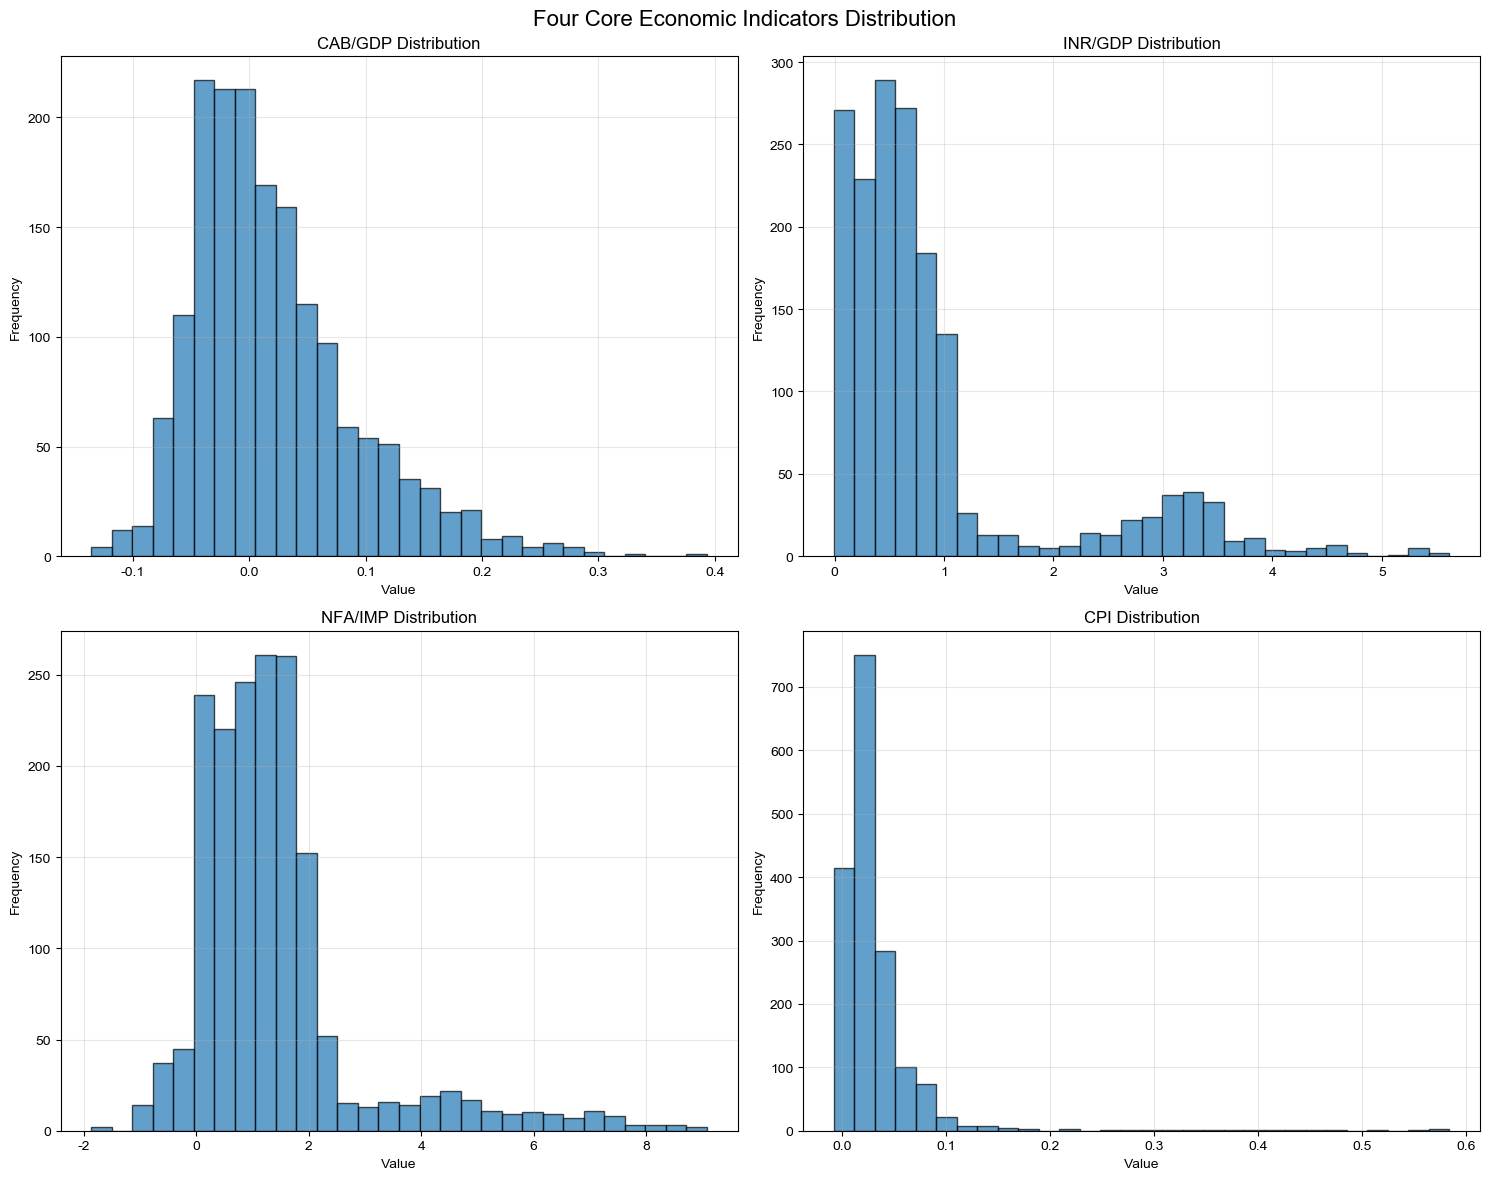

✅ 經濟指標描述性統計分析完成


In [24]:
# 視覺化經濟指標分布
import matplotlib.pyplot as plt
import seaborn as sns

# 設置中文字體支持
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Four Core Economic Indicators Distribution', fontsize=16, fontweight='bold')

# 從Eco字典獲取實際可用的指標資料
if 'Eco' in locals():
    indicators_data = {
        'CAB/GDP': Eco.get('current_account_balance'),
        'INR/GDP': Eco.get('international_reserve'), 
        'NFA/IMP': Eco.get('net_foreign_assets'),
        'CPI': Eco.get('cpi')
    }
else:
    indicators_data = {
        'CAB/GDP': None,
        'INR/GDP': None, 
        'NFA/IMP': None,
        'CPI': None
    }

plot_positions = [(0,0), (0,1), (1,0), (1,1)]

for i, (name, data) in enumerate(indicators_data.items()):
    row, col = plot_positions[i]
    
    if data is not None and not data.empty:
        # 繪製直方圖
        try:
            # 取出非空數值
            values = data.values.flatten()
            values = values[~pd.isna(values)]
            
            if len(values) > 0:
                axes[row, col].hist(values, bins=30, alpha=0.7, edgecolor='black')
                axes[row, col].set_title(f'{name} Distribution', fontweight='bold')
                axes[row, col].set_xlabel('Value')
                axes[row, col].set_ylabel('Frequency')
                axes[row, col].grid(True, alpha=0.3)
            else:
                axes[row, col].text(0.5, 0.5, f'{name}\nNo Valid Data', 
                                   ha='center', va='center', 
                                   transform=axes[row, col].transAxes,
                                   fontsize=12)
                axes[row, col].set_title(f'{name}', fontweight='bold')
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f'{name}\nError: {str(e)}', 
                               ha='center', va='center', 
                               transform=axes[row, col].transAxes,
                               fontsize=10)
            axes[row, col].set_title(f'{name}', fontweight='bold')
    else:
        axes[row, col].text(0.5, 0.5, f'{name}\nData Not Found', 
                           ha='center', va='center', 
                           transform=axes[row, col].transAxes,
                           fontsize=12)
        axes[row, col].set_title(f'{name}', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ 經濟指標描述性統計分析完成")


# 第三部分：迴歸分析與策略建構

## 3.1 匯率報酬計算與迴歸分析


# 準備迴歸分析所需的匯率報酬數據

In [25]:
# 計算匯率對數報酬率（半年期）
log_Mid_FX_Q = np.log(Mid_FX_Q)
Mid_FX_Q_half_year_ret = log_Mid_FX_Q - log_Mid_FX_Q.shift(2)  # 半年期報酬

# 根據交易策略時序安排：延遲一期開始持有，持有兩期，所以向前回推三期
Mid_FX_Q_half_year_ret_shifted = Mid_FX_Q_half_year_ret.shift(-3)
Mid_FX_Q_half_year_ret_shifted.dropna(inplace=True)

In [26]:
# 執行時間序列迴歸分析：經濟基本面 vs 匯率報酬

multi_regression_dict = {}  # 儲存迴歸數據
regression_result = {}      # 儲存迴歸係數
regression_pvalues = {}     # 儲存p值

for date in Eco['current_account_balance'].columns:
    # 準備該時期的迴歸數據
    data = {
        'current_account_balance': Eco['current_account_balance'][date],
        'international_reserve': Eco['international_reserve'][date], 
        'net_foreign_assets': Eco['net_foreign_assets'][date],
        'cpi': Eco['cpi'][date],
        'exchange_rate_ret': Mid_FX_Q_half_year_ret_shifted.loc[date]
    }
    
    df = pd.DataFrame(data)
    df.dropna(inplace=True)
    
    # 確保有足夠的觀測值進行迴歸
    if len(df) < 10:
        continue

    # 設置迴歸變數
    df['截距'] = 1
    x = df[['截距', 'current_account_balance', 'international_reserve', 'net_foreign_assets', 'cpi']]
    y = df['exchange_rate_ret']

    # 執行OLS迴歸
    model = sm.OLS(y, x).fit()

    # 儲存結果
    multi_regression_dict[date] = df
    regression_result[date] = model.params
    regression_pvalues[date] = model.pvalues

In [27]:
## 3.2 迴歸結果整理

# 整理迴歸係數為DataFrame格式
regression_result_df = pd.DataFrame(columns=['current_account_balance', 'international_reserve', 'net_foreign_assets', 'cpi'])
for date, params in regression_result.items():
    regression_result_df.loc[date, :] = params

# 整理p值為DataFrame格式  
regression_pvalues_df = pd.DataFrame(columns=['current_account_balance', 'international_reserve', 'net_foreign_assets', 'cpi'])
for date, pvalues in regression_pvalues.items():
    regression_pvalues_df.loc[date, :] = pvalues

## 迴歸結果

In [28]:
regression_result_df

,current_account_balance,international_reserve,net_foreign_assets,cpi
2002-03-29,0.372694,-0.009152,-0.019522,-0.150236
2002-06-28,-0.217294,-0.013614,-0.009096,-0.213101
2002-09-30,-0.34296,-0.014641,-0.005918,0.173785
2002-12-31,-0.014655,-0.013542,0.000641,0.302913
2003-03-31,0.001473,-0.009547,-0.010927,-0.183103
...,...,...,...,...
2022-06-30,-0.302313,0.005623,-0.001373,-0.616474
2022-09-30,-0.297431,0.000903,0.007238,-1.238922
2022-12-30,-0.070416,-0.008747,0.00347,-1.070911
2023-03-31,0.110747,-0.000696,-0.003397,-0.420319


In [29]:
regression_pvalues_df

,current_account_balance,international_reserve,net_foreign_assets,cpi
2002-03-29,0.49713,0.790224,0.239492,0.37277
2002-06-28,0.576052,0.571141,0.508354,0.118415
2002-09-30,0.519703,0.693468,0.751522,0.333024
2002-12-31,0.955064,0.514884,0.944744,0.010801
2003-03-31,0.996501,0.75093,0.394147,0.273021
...,...,...,...,...
2022-06-30,0.047307,0.590853,0.861282,0.032831
2022-09-30,0.083327,0.960603,0.567377,0.002928
2022-12-30,0.640443,0.441121,0.627901,0.000022
2023-03-31,0.156541,0.896362,0.265385,0.00006


In [30]:
## 3.3 顯著性篩選

# 僅保留顯著的迴歸係數（p值 ≤ 0.1）
regression_result_df_new = regression_result_df.copy()
for col in regression_result_df_new.columns:
    for idx in regression_result_df_new.index:
        if regression_pvalues_df.loc[idx, col] > 0.1:
            regression_result_df_new.at[idx, col] = np.NaN

## 3.4 迴歸結果視覺化


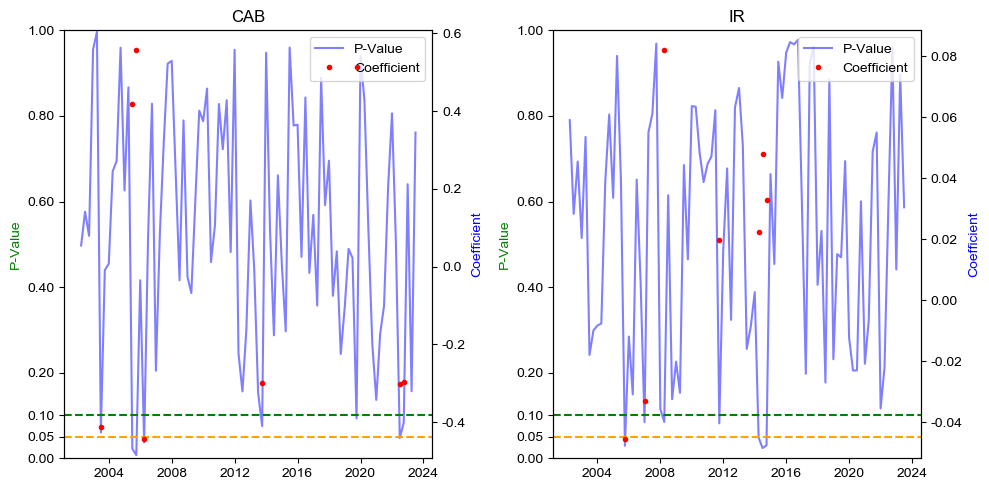

In [31]:
# 繪製圖形
plt.figure(figsize=(10, 5))

# 第一個子圖（current_account_balance）
ax1 = plt.subplot(1, 2, 1)
ax2 = ax1.twinx()
ax1.plot(regression_pvalues_df['current_account_balance'], 'b', label='P-Value', alpha=0.5)
ax2.plot(regression_result_df_new['current_account_balance'].dropna().index, 
         regression_result_df_new['current_account_balance'].dropna(), 
         'r.', label='Coefficient')  # 設置為單點，不連線
ax1.axhline(y=0.1, color='g', linestyle='--')
ax1.axhline(y=0.05, color='orange', linestyle='--')
ax1.set_ylim(0, 1)
ax1.set_ylabel('P-Value', color='g')
ax2.set_ylabel('Coefficient', color='b')
ax1.set_title('CAB')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')
ax1.set_yticks(list(ax1.get_yticks()) + [0.1, 0.05])

# 第二個子圖（international_reserve）
ax3 = plt.subplot(1, 2, 2)
ax4 = ax3.twinx()
ax3.plot(regression_pvalues_df['international_reserve'], 'b', label='P-Value', alpha=0.5)
ax4.plot(regression_result_df_new['international_reserve'].dropna().index, 
         regression_result_df_new['international_reserve'].dropna(), 
         'r.', label='Coefficient')  # 設置為單點，不連線
ax3.axhline(y=0.1, color='g', linestyle='--')
ax3.axhline(y=0.05, color='orange', linestyle='--')
ax3.set_ylim(0, 1)
ax3.set_ylabel('P-Value', color='g')
ax4.set_ylabel('Coefficient', color='b')
ax3.set_title('IR')
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc='upper right')
ax3.set_yticks(list(ax3.get_yticks()) + [0.1, 0.05])

# 調整子圖間的間距
plt.tight_layout()

# 顯示圖形
plt.show()

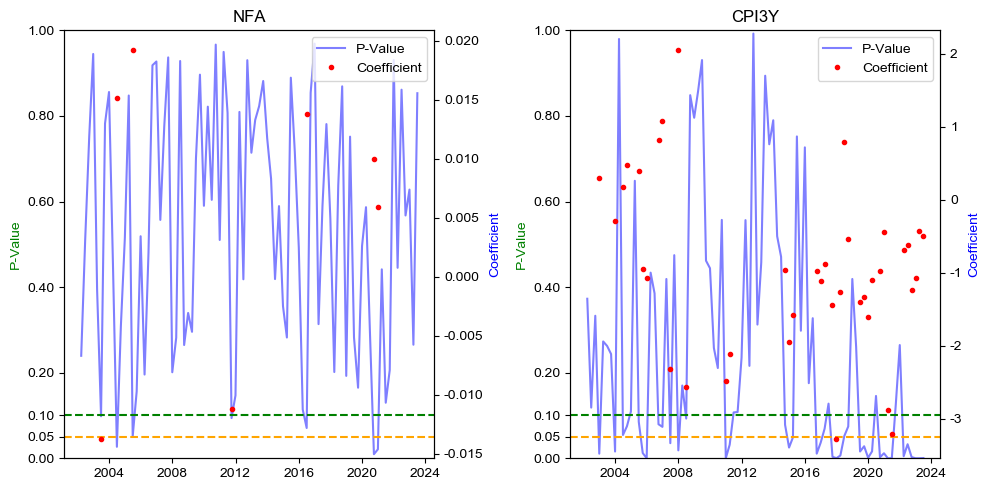

In [32]:
# 繪製圖形
plt.figure(figsize=(10, 5))

# 第一個子圖（current_account_balance）
ax1 = plt.subplot(1, 2, 1)
ax2 = ax1.twinx()
ax1.plot(regression_pvalues_df['net_foreign_assets'], 'b', label='P-Value', alpha=0.5)
ax2.plot(regression_result_df_new['net_foreign_assets'].dropna().index, 
         regression_result_df_new['net_foreign_assets'].dropna(), 
         'r.', label='Coefficient')  # 設置為單點，不連線
ax1.axhline(y=0.1, color='g', linestyle='--')
ax1.axhline(y=0.05, color='orange', linestyle='--')
ax1.set_ylim(0, 1)
ax1.set_ylabel('P-Value', color='g')
ax2.set_ylabel('Coefficient', color='b')
ax1.set_title('NFA')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')
ax1.set_yticks(list(ax1.get_yticks()) + [0.1, 0.05])

# 第二個子圖（international_reserve）
ax3 = plt.subplot(1, 2, 2)
ax4 = ax3.twinx()
ax3.plot(regression_pvalues_df['cpi'], 'b', label='P-Value', alpha=0.5)
ax4.plot(regression_result_df_new['cpi'].dropna().index, 
         regression_result_df_new['cpi'].dropna(), 
         'r.', label='Coefficient')  # 設置為單點，不連線
ax3.axhline(y=0.1, color='g', linestyle='--')
ax3.axhline(y=0.05, color='orange', linestyle='--')
ax3.set_ylim(0, 1)
ax3.set_ylabel('P-Value', color='g')
ax4.set_ylabel('Coefficient', color='b')
ax3.set_title('CPI3Y')
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc='upper right')
ax3.set_yticks(list(ax3.get_yticks()) + [0.1, 0.05])

# 調整子圖間的間距
plt.tight_layout()

# 顯示圖形
plt.show()

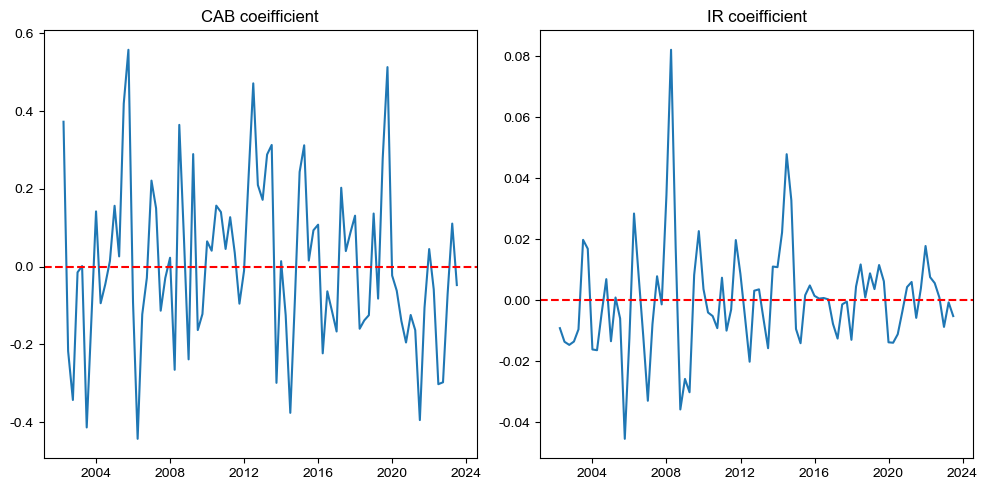

In [33]:
plt.figure(figsize=(10, 5))

# 第一個子圖（左側）
plt.subplot(1, 2, 1)
plt.plot(regression_result_df['current_account_balance'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('CAB coeifficient')

# 第二個子圖（右側）
plt.subplot(1, 2, 2)
plt.plot(regression_result_df['international_reserve'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('IR coeifficient')

# 調整子圖間的間距
plt.tight_layout()

# 顯示圖形
plt.show()

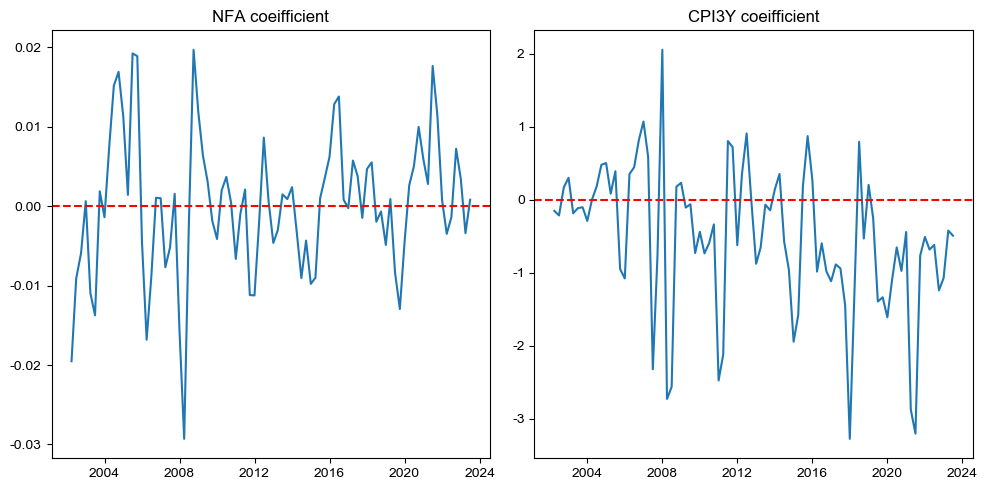

In [34]:
plt.figure(figsize=(10, 5))

# 第一個子圖（左側）
plt.subplot(1, 2, 1)
plt.plot(regression_result_df['net_foreign_assets'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('NFA coeifficient')

# 第二個子圖（右側）
plt.subplot(1, 2, 2)
plt.plot(regression_result_df['cpi'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('CPI3Y coeifficient')

# 調整子圖間的間距
plt.tight_layout()

# 顯示圖形
plt.show()

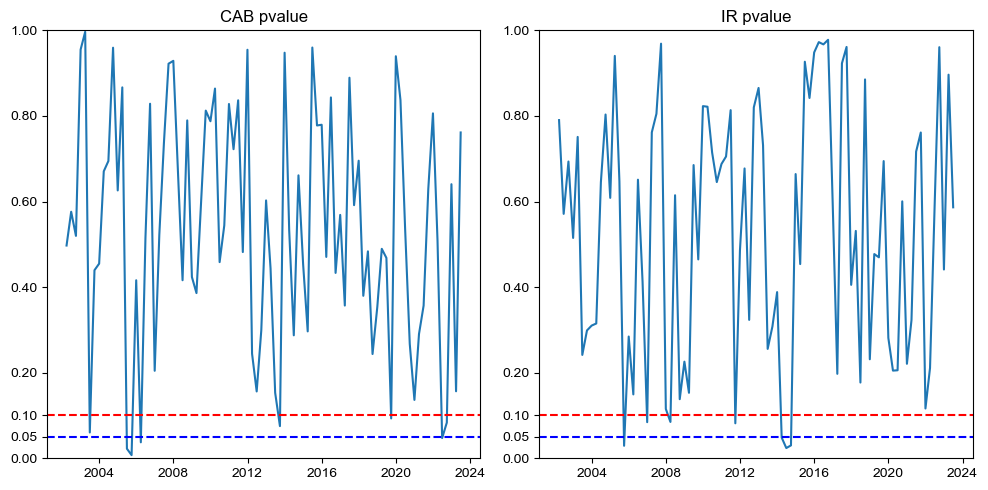

In [35]:
plt.figure(figsize=(10, 5))

# 第一個子圖（左側）
plt.subplot(1, 2, 1)
plt.plot(regression_pvalues_df['current_account_balance'])
plt.axhline(y=0.1, color='r', linestyle='--')
plt.axhline(y=0.05, color='b', linestyle='--')
plt.yticks(list(plt.yticks()[0]) + [0.1, 0.05])
plt.ylim(0, 1)
plt.title('CAB pvalue')

# 第二個子圖（右側）
plt.subplot(1, 2, 2)
plt.plot(regression_pvalues_df['international_reserve'])
plt.axhline(y=0.1, color='r', linestyle='--')
plt.axhline(y=0.05, color='b', linestyle='--')
plt.yticks(list(plt.yticks()[0]) + [0.1, 0.05])
plt.ylim(0, 1)
plt.title('IR pvalue')

# 調整子圖間的間距
plt.tight_layout()

# 顯示圖形
plt.show()

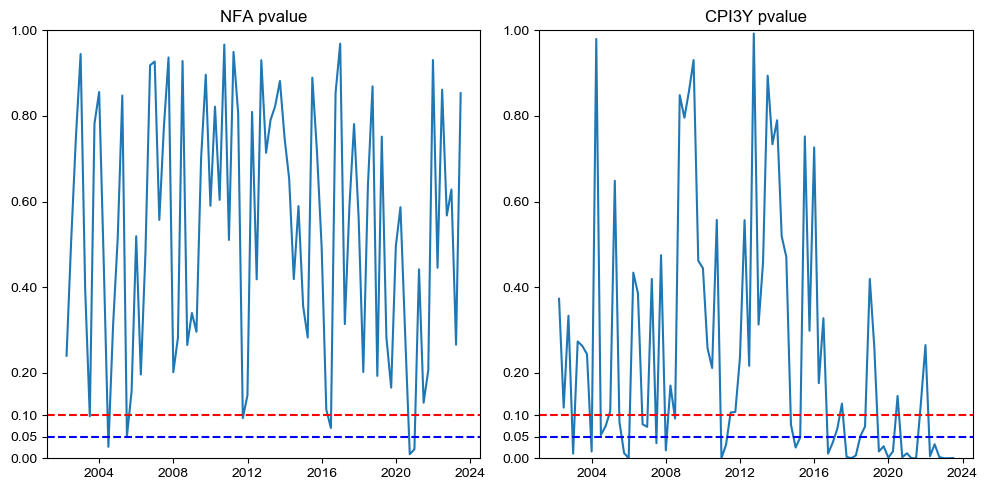

In [36]:
plt.figure(figsize=(10, 5))

# 第一個子圖（左側）
plt.subplot(1, 2, 1)
plt.plot(regression_pvalues_df['net_foreign_assets'])
plt.axhline(y=0.1, color='r', linestyle='--')
plt.axhline(y=0.05, color='b', linestyle='--')
plt.yticks(list(plt.yticks()[0]) + [0.1, 0.05])
plt.ylim(0, 1)
plt.title('NFA pvalue')

# 第二個子圖（右側）
plt.subplot(1, 2, 2)
plt.plot(regression_pvalues_df['cpi'])
plt.axhline(y=0.1, color='r', linestyle='--')
plt.axhline(y=0.05, color='b', linestyle='--')
plt.yticks(list(plt.yticks()[0]) + [0.1, 0.05])
plt.ylim(0, 1)
plt.title('CPI3Y pvalue')

# 調整子圖間的間距
plt.tight_layout()

# 顯示圖形
plt.show()

In [37]:
# 檢查哪些行的值都小於 0.1
rows_below_threshold = (regression_pvalues_df.shift(3).lt(0.1).sum(axis=1) >= 1)
regression_pvalues_df.shift(3)[rows_below_threshold]

,current_account_balance,international_reserve,net_foreign_assets,cpi
2003-09-30,0.955064,0.514884,0.944744,0.010801
2004-03-31,0.060288,0.241561,0.098239,0.262502
2004-09-30,0.454841,0.310063,0.85588,0.015786
2005-03-31,0.694602,0.64518,0.02682,0.054417
2005-06-30,0.959419,0.803279,0.308936,0.074765
2006-03-31,0.022366,0.646574,0.051073,0.085376
2006-06-30,0.007381,0.029185,0.156164,0.012172
2006-09-29,0.415988,0.284485,0.51883,0.000239
2006-12-29,0.037291,0.149248,0.195669,0.433754
2007-06-29,0.828466,0.412305,0.918295,0.079542


# 第四部分：交易策略構建與實施

## 4.0 VI策略（脆弱性指數策略）

VI策略基於各國經濟基本面脆弱性指標的策略，不包含利率成分。**此策略已在第二部分完成建構**，此處僅設定策略標識和說明。

**核心概念：**
- ✅ 使用純經濟基本面分析（第2部分已完成）
- ✅ 不依賴迴歸結果或利率差異
- ✅ 基於四個指標：CAB/GDP、INR/GDP、NFA/Imports、CPI  
- ✅ 已將國家分為五個脆弱性等級 (`total_rank_in_5`)


In [38]:
# VI Strategy: Vulnerability Index Strategy (純經濟基本面分析)
# 策略已在第二部分完成建構，此處僅設定策略標識和檢查結果

print("🎯 VI策略選擇 (VI Strategy Selection)")
print("VI策略投資組合已在第二部分建構完成")

# 檢查第二部分是否已建構VI策略分組
if 'vi_total_rank_in_5' in locals() and vi_total_rank_in_5 is not None:
    print("✅ 第二部分的VI策略分組已成功載入")
    print(f"✅ 投資組合建構完成，共有 {len(vi_total_rank_in_5.columns)} 個交易時期")
    
    # 顯示最新一期的投資組合分配
    latest_period = vi_total_rank_in_5.columns[-1]
    print(f"\n📊 最新一期({latest_period.strftime('%Y-%m-%d')})VI策略投資組合分配:")
    for portfolio in range(1, 6):
        countries_in_portfolio = vi_total_rank_in_5[latest_period][vi_total_rank_in_5[latest_period] == portfolio].index.tolist()
        countries_in_portfolio = [c for c in countries_in_portfolio if pd.notna(vi_total_rank_in_5.loc[c, latest_period])]
        print(f"投資組合{portfolio}: {countries_in_portfolio}")
    
    print(f"\n📝 投資組合邏輯說明:")
    print(f"• 投資組合1 = 最穩健國家 (經濟基本面最佳)")
    print(f"• 投資組合5 = 最脆弱國家 (經濟基本面最差)")
    print(f"• 交易策略: 做多P1, 做空P5")
    
else:
    print("❌ 錯誤：第二部分的VI策略分組未找到")
    print("請確保已執行第二部分的Cell 25")

# 設定當前策略為VI
CURRENT_STRATEGY = "VI"
print(f"\n🎯 當前策略設定為: {CURRENT_STRATEGY}")
print("✅ VI策略選擇完成")


🎯 VI策略選擇 (VI Strategy Selection)
VI策略投資組合已在第二部分建構完成
✅ 第二部分的VI策略分組已成功載入
✅ 投資組合建構完成，共有 86 個交易時期

📊 最新一期(2023-06-30)VI策略投資組合分配:
投資組合1: ['Denmark', 'Singapore', 'Korea', 'Taiwan']
投資組合2: ['Czech Republic', 'Japan', 'Norway', 'Switzerland']
投資組合3: ['Brazil', 'Poland', 'South Africa']
投資組合4: ['Australia', 'Hungary', 'Mexico', 'Sweden']
投資組合5: ['Canada', 'New Zealand', 'Turkey', 'United Kingdom', 'Euro Area']

📝 投資組合邏輯說明:
• 投資組合1 = 最穩健國家 (經濟基本面最佳)
• 投資組合5 = 最脆弱國家 (經濟基本面最差)
• 交易策略: 做多P1, 做空P5

🎯 當前策略設定為: VI
✅ VI策略選擇完成


## 4.1 RREVI策略（反向回歸增強投資策略）

RREVI策略是核心策略之一，基於經濟基本面的迴歸結果進行預測，並對係數取負號以實現反向邏輯。當經濟變數回歸係數不顯著時，該策略會收斂到CAR策略。


In [39]:
# RREVI策略實施
CURRENT_STRATEGY = "RREVI"
# 延遲2期以避免前瞻偏誤
params_for_predict = regression_result_df.shift(2).dropna()
pvalues_for_predict = regression_pvalues_df.shift(2).dropna()

# 建立超額報酬預測DataFrame
excess_ret_predict = pd.DataFrame(index=Eco['current_account_balance'].index,
                                  columns=params_for_predict.index)

for date in excess_ret_predict.columns:
    # 僅使用顯著係數（p值 ≤ 0.1），否則設為0
    current_account_balance_params = params_for_predict.loc[date, 'current_account_balance'] if pvalues_for_predict.loc[date, 'current_account_balance'] <= 0.1 else 0
    international_reserve_params = params_for_predict.loc[date, 'international_reserve'] if pvalues_for_predict.loc[date, 'international_reserve'] <= 0.1 else 0
    net_foreign_assets_params = params_for_predict.loc[date, 'net_foreign_assets'] if pvalues_for_predict.loc[date, 'net_foreign_assets'] <= 0.1 else 0
    cpi_params = params_for_predict.loc[date, 'cpi'] if pvalues_for_predict.loc[date, 'cpi'] <= 0.1 else 0
    
    # RREVI策略：對經濟基本面係數取負號（反向邏輯）+ CAR成分
    excess_ret_predict[date] = (
        -Eco['current_account_balance'][date] * current_account_balance_params +
        -Eco['international_reserve'][date] * international_reserve_params +
        -Eco['net_foreign_assets'][date] * net_foreign_assets_params +
        -Eco['cpi'][date] * cpi_params +
        ((-Mid_FX_FW_Q.shift(-1).loc[date] + Mid_FX_Q.shift(-1).loc[date]) / Mid_FX_Q.shift(-1).loc[date])
    )

## 4.2 CAR策略（利差交易策略）

CAR策略僅使用遠期與即期匯率價差，不使用經濟基本面數據。當所有經濟變數回歸係數都不顯著時，RREVI策略會收斂到此策略。


In [40]:
# CAR策略實施（如需要，請執行此cell而非上述RREVI策略cell）
CURRENT_STRATEGY = "CAR"
# 注意：僅能執行RREVI或CAR其中一個策略，後續所有分析將基於所選策略

params_for_predict = regression_result_df.shift(2).dropna()
pvalues_for_predict = regression_pvalues_df.shift(2).dropna()

excess_ret_predict = pd.DataFrame(index=Eco['current_account_balance'].index,
                                  columns=params_for_predict.index)

for date in excess_ret_predict.columns:
    # CAR策略：所有經濟基本面係數設為0，僅使用利率價差
    current_account_balance_params = 0
    international_reserve_params = 0
    net_foreign_assets_params = 0
    cpi_params = 0
    
    # 預測值僅包含遠期-即期價差（carry trade component）
    excess_ret_predict[date] = (
        Eco['current_account_balance'][date] * current_account_balance_params +
        Eco['international_reserve'][date] * international_reserve_params +
        Eco['net_foreign_assets'][date] * net_foreign_assets_params +
        Eco['cpi'][date] * cpi_params +
        ((-Mid_FX_FW_Q.shift(-1).loc[date] + Mid_FX_Q.shift(-1).loc[date]) / Mid_FX_Q.shift(-1).loc[date])
    )

In [41]:
# 設定當前策略名稱（用於圖表標題和後續分析）
# 請根據執行的策略修改此變數
# 可選值: "VI", "RREVI", "CAR", "REVI"

# 注意：如果已執行VI策略，CURRENT_STRATEGY可能已設定為"VI"
if 'CURRENT_STRATEGY' not in locals():
    CURRENT_STRATEGY = "RREVI"  # 預設策略

# 如果要覆蓋之前的策略設定，請取消下行註解並修改策略名稱
# CURRENT_STRATEGY = "RREVI"  # 強制設定為特定策略

print(f"📍 當前策略設定: {CURRENT_STRATEGY}")
print(f"📍 Current strategy: {CURRENT_STRATEGY}")

# 策略說明
strategy_descriptions = {
    "VI": "脆弱性指數策略 - 基於四個經濟基本面指標的純經濟分析",
    "CAR": "利差交易策略 - 僅使用遠期與即期匯率價差",
    "REVI": "回歸增強策略 - 基於經濟基本面迴歸 + 利差成分",
    "RREVI": "反向回歸增強策略 - 對經濟基本面係數取負號 + 利差成分"
}

if CURRENT_STRATEGY in strategy_descriptions:
    print(f"📝 策略說明: {strategy_descriptions[CURRENT_STRATEGY]}")
else:
    print("⚠️ 警告: 未識別的策略名稱")


📍 當前策略設定: CAR
📍 Current strategy: CAR
📝 策略說明: 利差交易策略 - 僅使用遠期與即期匯率價差


## 4.3 REVI策略說明

REVI策略可通過修改RREVI策略得到：將RREVI策略中的4個經濟變數前方的負號移除即可。
即將以下部分：
```python
-Eco['current_account_balance'][date] * current_account_balance_params
```
改為：
```python
Eco['current_account_balance'][date] * current_account_balance_params
```
其餘3個變數同理。


# 第五部分：投資組合構建與績效分析

## 5.1 預測值排名與投資組合分組


In [42]:
excess_ret_predict

,2002-09-30,2002-12-31,2003-03-31,2003-06-30,2003-09-30,2003-12-31,2004-03-31,2004-06-30,2004-09-30,2004-12-31,...,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-30,2023-03-31,2023-06-30
Name,,,,,,,,,,,,,,,,,,,,,
Australia,0.019821,0.016795,0.012839,0.013815,0.023544,0.017384,0.015794,0.011802,0.015017,0.013898,...,0.000307,-0.001204,-0.000577,-0.000762,-0.005091,0.000281,-0.011590,-0.004909,-0.006549,-0.003178
Brazil,NaN,NaN,NaN,NaN,NaN,0.006525,0.073551,0.067808,0.068397,0.062445,...,0.034514,0.036311,0.048698,0.053472,0.042426,0.037294,0.032618,0.034807,0.034830,0.015619
Canada,0.007416,0.010888,0.010128,0.007673,0.007180,0.004598,0.002134,0.002703,-0.000416,-0.002903,...,0.000040,0.000055,0.002038,0.000951,-0.000389,-0.001753,-0.002871,-0.002931,-0.003122,-0.002740
Czech Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001848,0.006421,0.018574,0.020012,0.019609,0.011622,0.007832,0.008387,0.004458,0.002849
Denmark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.003888,-0.003884,-0.005190,-0.008799,-0.015201,-0.014269,-0.013081,-0.011179,-0.012045,-0.010810
Hungary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003011,0.007386,0.020987,0.026469,0.030598,0.047037,0.048653,0.050782,0.036653,0.023976
Japan,-0.006696,-0.005863,-0.005789,-0.005852,-0.005874,-0.005859,-0.009681,-0.010934,-0.013802,-0.016870,...,-0.002120,-0.001873,-0.002596,-0.007102,-0.016944,-0.023456,-0.026009,-0.026987,-0.030422,-0.030554
Mexico,0.037587,0.036108,0.024513,0.022424,0.025766,0.024722,0.030285,0.030747,0.029799,0.032711,...,0.023654,0.026046,0.033745,0.033894,0.035160,0.032890,0.033552,0.035314,0.033791,0.030644
New Zealand,0.020073,0.020876,0.016226,0.018185,0.023839,0.017743,0.020077,0.019826,0.024849,0.020088,...,0.000713,0.002929,0.004630,0.006859,-0.001976,0.009174,-0.003888,0.000526,0.000769,0.002063


In [43]:
# 對預測的超額報酬進行排名（數值越大排名越前）
predicted_excess_ret_rank = excess_ret_predict.rank(axis=0, method='min', ascending=False)

In [44]:
# 第五部分：投資組合構建與績效分析

## 5.1 預測值排名與投資組合分組

# 🔧 解決變數命名衝突問題：為不同策略創建獨立變數
print("📋 策略變數管理與分組建構")
print("=" * 50)

# 根據當前策略設定投資組合分組
if CURRENT_STRATEGY == "VI":
    # VI策略使用專屬變數 vi_total_rank_in_5
    if 'vi_total_rank_in_5' in locals():
        # 為VI策略創建用於後續分析的分組變數
        total_rank_in_5 = vi_total_rank_in_5.copy()
        print(f"✅ 使用 {CURRENT_STRATEGY} 策略的脆弱性綜合排名")
        print(f"✅ VI策略投資組合來源：第二部分(Cell 25)")
        print(f"📝 已將vi_total_rank_in_5複製到total_rank_in_5")
    else:
        print(f"❌ 錯誤：VI策略專用變數 'vi_total_rank_in_5' 未找到")
        print("請確保已執行第二部分的Cell 25")
    
elif CURRENT_STRATEGY in ["RREVI", "CAR", "REVI"]:
    # 基於迴歸的策略：使用預測值排名
    if 'predicted_excess_ret_rank' in locals():
        # 為迴歸策略建構專屬分組變數
        regression_total_rank_in_5 = predicted_excess_ret_rank.apply(lambda x: x.map(lambda y: map_rank_to_group(y, x.max())), axis=0)
        total_rank_in_5 = regression_total_rank_in_5.copy()
        print(f"✅ 使用 {CURRENT_STRATEGY} 策略的預測排名")
        print(f"📝 已建構 {CURRENT_STRATEGY} 策略專用變數 'regression_total_rank_in_5'")
        print(f"📝 已將regression_total_rank_in_5複製到total_rank_in_5")
    else:
        print(f"❌ 錯誤：請先執行 {CURRENT_STRATEGY} 策略實施代碼")
        print(f"❌ Error: Please run {CURRENT_STRATEGY} strategy implementation first")
else:
    print(f"❌ 錯誤：未知策略 {CURRENT_STRATEGY}")
    print(f"❌ Error: Unknown strategy {CURRENT_STRATEGY}")

# 顯示結果
if 'total_rank_in_5' in locals():
    print(f"\n📊 {CURRENT_STRATEGY}策略投資組合分組結果:")
    print(f"📊 Strategy: {CURRENT_STRATEGY}")
    print(f"📊 Portfolio periods: {len(total_rank_in_5.columns)}")
    print("📝 變數說明：")
    if CURRENT_STRATEGY == "VI":
        print("   • vi_total_rank_in_5: VI策略專用變數（永久保存）")
        print("   • total_rank_in_5: 當前分析用變數（來源：vi_total_rank_in_5）")
    else:
        print("   • regression_total_rank_in_5: 迴歸策略專用變數（永久保存）")
        print("   • total_rank_in_5: 當前分析用變數（來源：regression_total_rank_in_5）")
    display(total_rank_in_5)
else:
    print("❌ 分組建構失敗，無法顯示結果")


📋 策略變數管理與分組建構
✅ 使用 CAR 策略的預測排名
📝 已建構 CAR 策略專用變數 'regression_total_rank_in_5'
📝 已將regression_total_rank_in_5複製到total_rank_in_5

📊 CAR策略投資組合分組結果:
📊 Strategy: CAR
📊 Portfolio periods: 84
📝 變數說明：
   • regression_total_rank_in_5: 迴歸策略專用變數（永久保存）
   • total_rank_in_5: 當前分析用變數（來源：regression_total_rank_in_5）


,2002-09-30,2002-12-31,2003-03-31,2003-06-30,2003-09-30,2003-12-31,2004-03-31,2004-06-30,2004-09-30,2004-12-31,...,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-30,2023-03-31,2023-06-30
Name,,,,,,,,,,,,,,,,,,,,,
Australia,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,...,3,4,4,3,4,3,4,3,3,3
Brazil,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
Canada,4.0,4.0,4.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,...,3,3,3,3,2,3,3,3,3,3
Czech Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,2,2,2,2
Denmark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,5,5,5,5,5,5,5,5,4
Hungary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,1,1,1,1,1,1,1
Japan,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,4,4,5,4,5,5,5,5,5,5
Mexico,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
New Zealand,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,2,2,2,2,3,2,3,2,2,2


## 5.2 投資組合轉換矩陣分析


### transition matrix

In [45]:
port_names = ('P1', 'P2', 'P3', 'P4', 'P5')
tran_matrix = pd.DataFrame(0, columns = port_names,
                        index = port_names)
idxname = total_rank_in_5.index
for idx in idxname:
    # colname = total_rank_in_5.loc[idx].dropna().index
    colname = total_rank_in_5.iloc[:,23:].loc[idx].dropna().index
    for col_num in range(len(colname[:-1])):
        last_group = int(total_rank_in_5.loc[idx, colname[col_num]])
        group = int(total_rank_in_5.loc[idx, colname[col_num+1]])
        tran_matrix.at[f'P{last_group}', f'P{group}'] += 1
# value_counts = total_rank_in_5[total_rank_in_5.columns[:-1]].stack().value_counts()
value_counts = total_rank_in_5[total_rank_in_5.iloc[:,23:].columns[:-1]].stack().value_counts()
for groups in range(1,6):
    tran_matrix.loc[f'P{groups}'] /= value_counts[groups]

In [46]:
tran_matrix

,P1,P2,P3,P4,P5
P1,0.920833,0.075000,0.000000,0.000000,0.004167
P2,0.073913,0.695652,0.217391,0.013043,0.000000
P3,0.004255,0.195745,0.591489,0.182979,0.025532
P4,0.000000,0.026087,0.169565,0.569565,0.234783
P5,0.000000,0.004167,0.029167,0.220833,0.745833


### 超額報酬

In [47]:
holding_period = 2
Excess_ret = (Mid_FX_Q-Mid_FX_FW_Q.shift(holding_period))/Mid_FX_Q.shift(holding_period)
Excess_ret = Excess_ret.shift(-holding_period)
# Excess_ret.dropna(inplace=True)
total_rank_in_5_shifted = total_rank_in_5.shift(1, axis=1)
total_port_3m = {}
for port in range(1,6):
    FX_position = pd.DataFrame(columns=Excess_ret.columns, index=Excess_ret.index)
    for dt in total_rank_in_5_shifted.columns:
        cur = list(total_rank_in_5_shifted[total_rank_in_5_shifted.loc[:,dt]==port].index)
        weight = 1/len(cur) if cur else 0
        FX_position.loc[dt,cur] = weight

    FX_position.dropna(how='all', inplace=True)
    total_port_3m[f'total_port{port}'] = FX_position

<Figure size 1000x800 with 0 Axes>

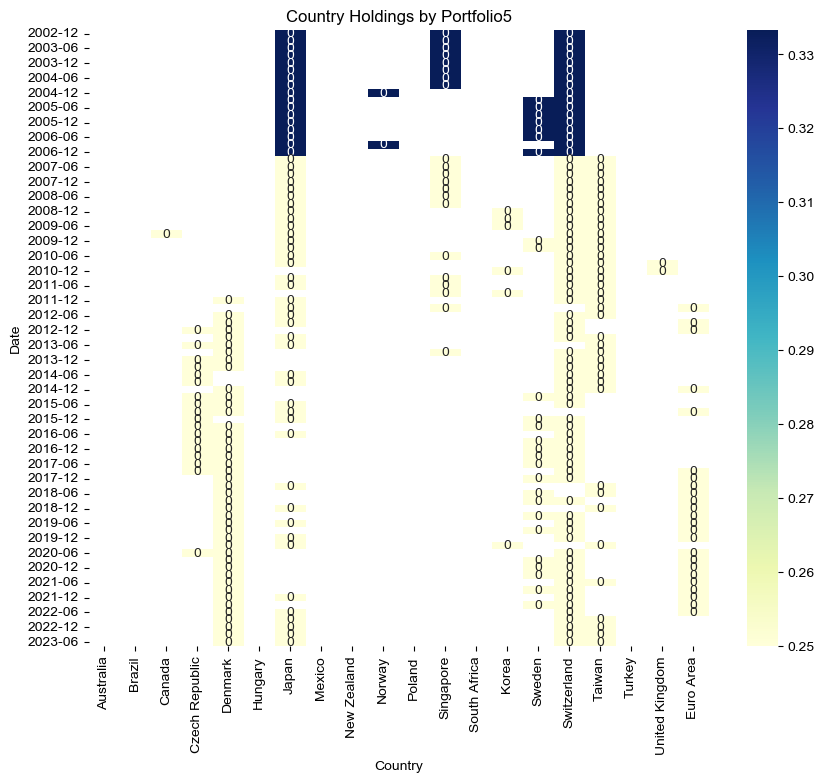

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(10, 8))

# 绘制热力图
test_df = total_port_3m['total_port5'].astype(float)
# 首先，将索引转换为 datetime 类型
test_df.index = pd.to_datetime(test_df.index)
# 然后，使用 strftime 方法将日期格式化为月份字符串
test_df.index = test_df.index.strftime('%Y-%m')

# 现在，绘制热力图，并只显示到月份的索引
plt.figure(figsize=(10, 8))
sns.heatmap(test_df, cmap="YlGnBu", annot=True, fmt=".0f", xticklabels=True)
plt.title("Country Holdings by Portfolio5")
plt.xlabel("Country")
plt.ylabel("Date")
plt.show()

In [49]:
total_port_3m_ret = {}
for key, df in total_port_3m.items():
    ret = Excess_ret * df
    ret.dropna(how='all', inplace=True)
    ret['Sum_ret'] = ret.sum(axis=1)
    total_port_3m_ret[key] = ret

# 看看08年之後的表現
Excess_ret_after2008 = Excess_ret.loc[Excess_ret.index>pd.to_datetime('2008-01-01')]
total_port_3m_ret_after2008 = {}
for key, df in total_port_3m.items():
    ret = Excess_ret_after2008 * df
    ret.dropna(how='all', inplace=True)
    ret['Sum_ret'] = ret.sum(axis=1)
    total_port_3m_ret_after2008[key] = ret

In [50]:
summary_index = ('Mean', 'St. dev.', 'Skew', 'Kurt', 'SR', 'AC', 'Freq')
summary_columns = ('P1', 'P2', 'P3', 'P4', 'P5', 'P1-P5')

summary = pd.DataFrame(index=summary_index, columns=summary_columns)
for port in range(1,7):
    if port<=5:
        ret = total_port_3m_ret[f'total_port{port}']['Sum_ret']*100 #乘以100會影響mean和st.dev. 這樣顯示的結果為報酬率%數
        col_name = f'P{port}'
        #這邊先計算freq
        port_df = total_port_3m[f'total_port{port}']
        # 初始化列表存储变化比例
        changes = []
        # 计算变化比例
        for i in range(1, len(port_df)):
            prev_positions = set(port_df.iloc[i - 1].dropna().index)
            curr_positions = set(port_df.iloc[i].dropna().index)
            intersection = prev_positions.intersection(curr_positions)
            change_ratio = 1-(len(intersection) / len(prev_positions))
            changes.append(change_ratio)
    else:
        ret = (total_port_3m_ret[f'total_port1']['Sum_ret']-total_port_3m_ret[f'total_port5']['Sum_ret'])*100
        col_name = summary_columns[-1]
    
    mutilpier = 4/holding_period
    summary.loc['Mean',col_name] = ret.mean()*mutilpier  #年化，顯示為年化報酬率
    summary.loc['St. dev.',col_name] = ret.std()*np.sqrt(mutilpier) #年化，顯示為年化報酬率標準差
    summary.loc['Skew',col_name] = ret.skew()
    summary.loc['Kurt',col_name] = ret.kurt()
    summary.loc['SR',col_name] = (ret.mean()*mutilpier)/(ret.std()*np.sqrt(mutilpier)) #年化
    summary.loc['AC',col_name] = ret.autocorr()
    summary.loc['Freq',col_name] = np.mean(changes)

In [51]:
import numpy as np
import pandas as pd
from scipy import stats

summary_index = ('Mean', 'St. dev.', 'Skew', 'Kurt', 'SR', 'AC', 'Freq', 'Significance')
summary_columns = ('P1', 'P2', 'P3', 'P4', 'P5', 'P1-P5')

summary = pd.DataFrame(index=summary_index, columns=summary_columns)

for port in range(1, 7):
    if port <= 5:
        ret = total_port_3m_ret[f'total_port{port}']['Sum_ret'] * 100  # 乘以100會影響mean和st.dev. 顯示的結果為報酬率%
        col_name = f'P{port}'
        # 計算freq
        port_df = total_port_3m[f'total_port{port}']
        # 初始化列表存储变化比例
        changes = []
        # 计算变化比例
        for i in range(1, len(port_df)):
            prev_positions = set(port_df.iloc[i - 1].dropna().index)
            curr_positions = set(port_df.iloc[i].dropna().index)
            intersection = prev_positions.intersection(curr_positions)
            change_ratio = 1 - (len(intersection) / len(prev_positions))
            changes.append(change_ratio)
    else:
        ret = (total_port_3m_ret[f'total_port1']['Sum_ret'] - total_port_3m_ret[f'total_port5']['Sum_ret']) * 100
        col_name = summary_columns[-1]
    
    multiplier = 4 / holding_period
    mean_return = ret.mean() * multiplier  # 年化，顯示為年化報酬率
    std_return = ret.std() * np.sqrt(multiplier)  # 年化，顯示為年化報酬率標準差
    
    summary.loc['Mean', col_name] = mean_return
    summary.loc['St. dev.', col_name] = std_return
    summary.loc['Skew', col_name] = ret.skew()
    summary.loc['Kurt', col_name] = ret.kurt()
    summary.loc['SR', col_name] = mean_return / std_return  # 年化
    summary.loc['AC', col_name] = ret.autocorr()
    summary.loc['Freq', col_name] = np.mean(changes)
    
    # 添加t檢驗來檢查報酬率是否顯著異於零
    t_stat, p_value = stats.ttest_1samp(ret, 0)
    one_tailed_p_value = p_value / 2 if t_stat > 0 else 1 - (p_value / 2)
    summary.loc['Significance', col_name] = one_tailed_p_value

summary

,P1,P2,P3,P4,P5,P1-P5
Mean,4.464024,2.200291,0.384506,-0.244544,-0.75707,5.221094
St. dev.,12.029641,11.488935,9.199197,8.516348,7.145394,11.039927
Skew,-0.341504,-0.004368,-0.539715,-0.101894,0.068087,-0.272554
Kurt,0.007733,1.231342,0.843704,0.024103,-0.221915,0.692049
SR,0.371085,0.191514,0.041798,-0.028715,-0.105952,0.472928
AC,0.490178,0.44901,0.506032,0.48911,0.421821,0.461763
Freq,0.094512,0.315041,0.405488,0.390244,0.203252,0.203252
Significance,0.009557,0.110412,0.394202,0.57315,0.751592,0.001556


In [52]:
summary_after2008 = pd.DataFrame(index=summary_index, columns=summary_columns)

for port in range(1, 7):
    if port <= 5:
        ret = total_port_3m_ret_after2008[f'total_port{port}']['Sum_ret'] * 100  # 乘以100會影響mean和st.dev. 顯示的結果為報酬率%
        col_name = f'P{port}'
        # 計算freq
        port_df = total_port_3m[f'total_port{port}']
        # 初始化列表存储变化比例
        changes = []
        # 计算变化比例
        for i in range(1, len(port_df)):
            prev_positions = set(port_df.iloc[i - 1].dropna().index)
            curr_positions = set(port_df.iloc[i].dropna().index)
            intersection = prev_positions.intersection(curr_positions)
            change_ratio = 1 - (len(intersection) / len(prev_positions))
            changes.append(change_ratio)
    else:
        ret = (total_port_3m_ret_after2008[f'total_port1']['Sum_ret'] - total_port_3m_ret_after2008[f'total_port5']['Sum_ret']) * 100
        col_name = summary_columns[-1]
    
    multiplier = 4 / holding_period
    mean_return = ret.mean() * multiplier  # 年化，顯示為年化報酬率
    std_return = ret.std() * np.sqrt(multiplier)  # 年化，顯示為年化報酬率標準差
    
    summary_after2008.loc['Mean', col_name] = mean_return
    summary_after2008.loc['St. dev.', col_name] = std_return
    summary_after2008.loc['Skew', col_name] = ret.skew()
    summary_after2008.loc['Kurt', col_name] = ret.kurt()
    summary_after2008.loc['SR', col_name] = mean_return / std_return  # 年化
    summary_after2008.loc['AC', col_name] = ret.autocorr()
    summary_after2008.loc['Freq', col_name] = np.mean(changes)
    
    # 添加t檢驗來檢查報酬率是否顯著異於零
    t_stat, p_value = stats.ttest_1samp(ret, 0)
    one_tailed_p_value = p_value / 2 if t_stat > 0 else 1 - (p_value / 2)
    summary_after2008.loc['Significance', col_name] = one_tailed_p_value

In [53]:
summary_after2008

,P1,P2,P3,P4,P5,P1-P5
Mean,0.206934,-0.616037,-2.590517,-2.444461,-1.664529,1.871463
St. dev.,11.674466,11.511015,9.100123,8.142535,7.021665,9.861125
Skew,-0.192487,0.119699,-0.465992,-0.109712,0.192545,-0.869542
Kurt,0.238791,1.914649,0.982387,0.153501,0.035319,0.74016
SR,0.017725,-0.053517,-0.284668,-0.300209,-0.237056,0.189782
AC,0.399775,0.439846,0.474869,0.460818,0.424694,0.363534
Freq,0.094512,0.315041,0.405488,0.390244,0.203252,0.203252
Significance,0.460854,0.616631,0.940927,0.950126,0.904095,0.147417


In [54]:
# 看看08年之後的表現
reg_pvalue_after2008 = regression_pvalues_df.loc[regression_pvalues_df.index>pd.to_datetime('2008-01-01')]
rows_below_threshold = (reg_pvalue_after2008.shift(3).lt(0.1).sum(axis=1)>=1)
reg_pvalue_after2008.shift(3)[rows_below_threshold]

,current_account_balance,international_reserve,net_foreign_assets,cpi
2008-12-31,0.670428,0.084888,0.281846,0.169985
2009-03-31,0.416045,0.614639,0.928304,0.092827
2011-09-30,0.827894,0.687599,0.510119,0.000184
2011-12-30,0.72226,0.705166,0.949573,0.031699
2012-06-29,0.481905,0.081734,0.093914,0.108084
2014-06-30,0.075165,0.308154,0.88158,0.733774
2014-12-31,0.533737,0.048447,0.653023,0.518943
2015-03-31,0.287318,0.023915,0.41877,0.4708
2015-06-30,0.66114,0.030118,0.58926,0.078211
2015-09-30,0.45281,0.664136,0.355494,0.02508


In [55]:
rows_below_threshold = (regression_pvalues_df.shift(3).lt(0.1).sum(axis=1)>=1)
regression_pvalues_df.shift(3)[rows_below_threshold].index

DatetimeIndex(['2003-09-30', '2004-03-31', '2004-09-30', '2005-03-31',
               '2005-06-30', '2006-03-31', '2006-06-30', '2006-09-29',
               '2006-12-29', '2007-06-29', '2007-09-28', '2008-03-31',
               '2008-09-30', '2008-12-31', '2009-03-31', '2011-09-30',
               '2011-12-30', '2012-06-29', '2014-06-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2017-03-31', '2017-06-30', '2017-09-29', '2017-12-29',
               '2018-06-29', '2018-09-28', '2018-12-31', '2019-03-29',
               '2019-06-28', '2020-03-31', '2020-06-30', '2020-09-30',
               '2020-12-31', '2021-06-30', '2021-09-30', '2021-12-31',
               '2022-03-31', '2022-12-30', '2023-03-31', '2023-06-30'],
              dtype='datetime64[ns]', freq=None)

In [56]:
# 📊 顯著性p值篩選後的績效分析（2008年後）
# 修正Boolean索引警告問題

summary_index = ('Mean', 'St. dev.', 'Skew', 'Kurt', 'SR', 'AC', 'Freq')
summary_columns = ('P1', 'P2', 'P3', 'P4', 'P5', 'P1-P5')

summary_for_pvalue_under10_after2008 = pd.DataFrame(index=summary_index, columns=summary_columns)

# ✅ 修正1：正確處理Boolean索引，避免reindex警告
# 確保rows_below_threshold與reg_pvalue_after2008有相同的索引
valid_rows_after2008 = rows_below_threshold.reindex(reg_pvalue_after2008.index, fill_value=False)
significant_dates = reg_pvalue_after2008[valid_rows_after2008].index

print(f"📈 找到 {len(significant_dates)} 個顯著期間用於分析")

for port in range(1,7):
    if port<=5:
        # ✅ 修正2：直接使用篩選後的日期，避免迭代修改
        temp_date = significant_dates.intersection(total_port_3m_ret_after2008[f'total_port{port}'].index)
        
        if len(temp_date) == 0:
            print(f"⚠️ 警告：投資組合P{port}沒有有效的顯著期間數據")
            continue
            
        ret = total_port_3m_ret_after2008[f'total_port{port}'].loc[temp_date]['Sum_ret']*100
        col_name = f'P{port}'
        
        # 計算投資組合轉換頻率
        port_df = total_port_3m[f'total_port{port}'].loc[temp_date]
        changes = []
        for i in range(1, len(port_df)):
            prev_positions = set(port_df.iloc[i - 1].dropna().index)
            curr_positions = set(port_df.iloc[i].dropna().index)
            if len(prev_positions) > 0:  # ✅ 修正3：避免除零錯誤
                intersection = prev_positions.intersection(curr_positions)
                change_ratio = 1-(len(intersection) / len(prev_positions))
                changes.append(change_ratio)
    else:
        # P1-P5差額計算
        temp_date = significant_dates.intersection(
            total_port_3m_ret_after2008[f'total_port1'].index
        ).intersection(
            total_port_3m_ret_after2008[f'total_port5'].index
        )
        
        if len(temp_date) == 0:
            print(f"⚠️ 警告：P1-P5差額沒有有效的顯著期間數據")
            continue
            
        ret = (total_port_3m_ret_after2008[f'total_port1'].loc[temp_date]['Sum_ret'] - 
               total_port_3m_ret_after2008[f'total_port5'].loc[temp_date]['Sum_ret']) * 100
        col_name = summary_columns[-1]
    
    # ✅ 修正4：增加數據有效性檢查
    if len(ret) == 0 or ret.isna().all():
        print(f"⚠️ 警告：{col_name}沒有有效的報酬數據")
        continue
    
    # 計算統計指標
    mutilpier = 4/holding_period
    summary_for_pvalue_under10_after2008.loc['Mean',col_name] = ret.mean()*mutilpier
    summary_for_pvalue_under10_after2008.loc['St. dev.',col_name] = ret.std()*np.sqrt(mutilpier)
    summary_for_pvalue_under10_after2008.loc['Skew',col_name] = ret.skew()
    summary_for_pvalue_under10_after2008.loc['Kurt',col_name] = ret.kurt()
    summary_for_pvalue_under10_after2008.loc['SR',col_name] = (ret.mean()*mutilpier)/(ret.std()*np.sqrt(mutilpier))
    summary_for_pvalue_under10_after2008.loc['AC',col_name] = ret.autocorr()
    
    # ✅ 修正5：安全處理changes計算
    if port <= 5 and len(changes) > 0:
        summary_for_pvalue_under10_after2008.loc['Freq',col_name] = np.mean(changes)
    elif port <= 5:
        summary_for_pvalue_under10_after2008.loc['Freq',col_name] = np.nan
    
    # t檢驗顯著性測試
    try:
        t_stat, p_value = stats.ttest_1samp(ret.dropna(), 0)
        one_tailed_p_value = p_value / 2 if t_stat > 0 else 1 - (p_value / 2)
        summary_for_pvalue_under10_after2008.loc['Significance', col_name] = one_tailed_p_value
    except:
        summary_for_pvalue_under10_after2008.loc['Significance', col_name] = np.nan

📈 找到 33 個顯著期間用於分析


In [57]:
# 📊 顯著性p值篩選後的績效分析（全期間）
# 修正Boolean索引警告問題

summary_index = ('Mean', 'St. dev.', 'Skew', 'Kurt', 'SR', 'AC', 'Freq')
summary_columns = ('P1', 'P2', 'P3', 'P4', 'P5', 'P1-P5')

summary_for_pvalue_under10 = pd.DataFrame(index=summary_index, columns=summary_columns)

# ✅ 修正Boolean索引：正確處理rows_below_threshold
# 確保索引對齊，避免reindex警告
valid_rows = rows_below_threshold.reindex(regression_pvalues_df.index, fill_value=False)
significant_dates_all = regression_pvalues_df[valid_rows].index

print(f"📈 全期間找到 {len(significant_dates_all)} 個顯著期間用於分析")

for port in range(1,7):
    if port<=5:
        # ✅ 使用索引交集，確保數據存在
        valid_dates = significant_dates_all.intersection(total_port_3m_ret[f'total_port{port}'].index)
        
        if len(valid_dates) == 0:
            print(f"⚠️ 警告：投資組合P{port}沒有有效的顯著期間數據")
            continue
            
        ret = total_port_3m_ret[f'total_port{port}'].loc[valid_dates]['Sum_ret']*100
        col_name = f'P{port}'
        
        # 計算投資組合轉換頻率
        port_df = total_port_3m[f'total_port{port}'].loc[valid_dates]
        changes = []
        for i in range(1, len(port_df)):
            prev_positions = set(port_df.iloc[i - 1].dropna().index)
            curr_positions = set(port_df.iloc[i].dropna().index)
            if len(prev_positions) > 0:  # 避免除零錯誤
                intersection = prev_positions.intersection(curr_positions)
                change_ratio = 1-(len(intersection) / len(prev_positions))
                changes.append(change_ratio)
    else:
        # P1-P5差額計算，確保兩個投資組合都有數據
        valid_dates = significant_dates_all.intersection(
            total_port_3m_ret[f'total_port1'].index
        ).intersection(
            total_port_3m_ret[f'total_port5'].index
        )
        
        if len(valid_dates) == 0:
            print(f"⚠️ 警告：P1-P5差額沒有有效的顯著期間數據")
            continue
            
        ret = (total_port_3m_ret[f'total_port1'].loc[valid_dates]['Sum_ret'] - 
               total_port_3m_ret[f'total_port5'].loc[valid_dates]['Sum_ret']) * 100
        col_name = summary_columns[-1]
    
    # 數據有效性檢查
    if len(ret) == 0 or ret.isna().all():
        print(f"⚠️ 警告：{col_name}沒有有效的報酬數據")
        continue
    
    # 計算統計指標
    mutilpier = 4/holding_period
    summary_for_pvalue_under10.loc['Mean',col_name] = ret.mean()*mutilpier
    summary_for_pvalue_under10.loc['St. dev.',col_name] = ret.std()*np.sqrt(mutilpier)
    summary_for_pvalue_under10.loc['Skew',col_name] = ret.skew()
    summary_for_pvalue_under10.loc['Kurt',col_name] = ret.kurt()
    summary_for_pvalue_under10.loc['SR',col_name] = (ret.mean()*mutilpier)/(ret.std()*np.sqrt(mutilpier))
    summary_for_pvalue_under10.loc['AC',col_name] = ret.autocorr()
    
    # 安全處理changes計算
    if port <= 5 and len(changes) > 0:
        summary_for_pvalue_under10.loc['Freq',col_name] = np.mean(changes)
    elif port <= 5:
        summary_for_pvalue_under10.loc['Freq',col_name] = np.nan

    # t檢驗顯著性測試
    try:
        t_stat, p_value = stats.ttest_1samp(ret.dropna(), 0)
        one_tailed_p_value = p_value / 2 if t_stat > 0 else 1 - (p_value / 2)
        summary_for_pvalue_under10.loc['Significance', col_name] = one_tailed_p_value
    except:
        summary_for_pvalue_under10.loc['Significance', col_name] = np.nan

📈 全期間找到 44 個顯著期間用於分析


In [58]:
summary_for_pvalue_under10_after2008

,P1,P2,P3,P4,P5,P1-P5
Mean,2.222403,-0.088879,-2.42393,-1.822252,-2.796985,5.019387
St. dev.,10.830605,11.638375,8.964881,8.472551,7.382946,9.267028
Skew,0.050926,0.723343,-0.251379,0.028039,0.178118,-0.802956
Kurt,0.872575,2.749062,0.699971,0.326218,0.252851,0.674207
SR,0.205197,-0.007637,-0.270381,-0.215077,-0.378844,0.541639
AC,0.29084,0.363668,0.366803,0.365916,0.3663,0.19578
Freq,0.085938,0.348958,0.455729,0.479167,0.273438,NaN
Significance,0.205367,0.512277,0.859864,0.80559,0.933167,0.017567


In [59]:
summary_for_pvalue_under10

,P1,P2,P3,P4,P5,P1-P5
Mean,5.598077,2.253534,0.026302,-0.329754,-1.835737,7.433815
St. dev.,10.923613,10.932387,8.516485,7.82961,7.391753,10.371678
Skew,-0.190124,0.391136,-0.595013,-0.286717,0.139478,-0.19923
Kurt,0.264719,2.228463,0.882601,0.485218,0.093049,0.604957
SR,0.512475,0.206134,0.003088,-0.042116,-0.248349,0.716742
AC,0.319868,0.336926,0.375692,0.315954,0.242066,0.200968
Freq,0.108527,0.375969,0.467054,0.457364,0.234496,NaN
Significance,0.010306,0.169512,0.494255,0.577833,0.874752,0.000817


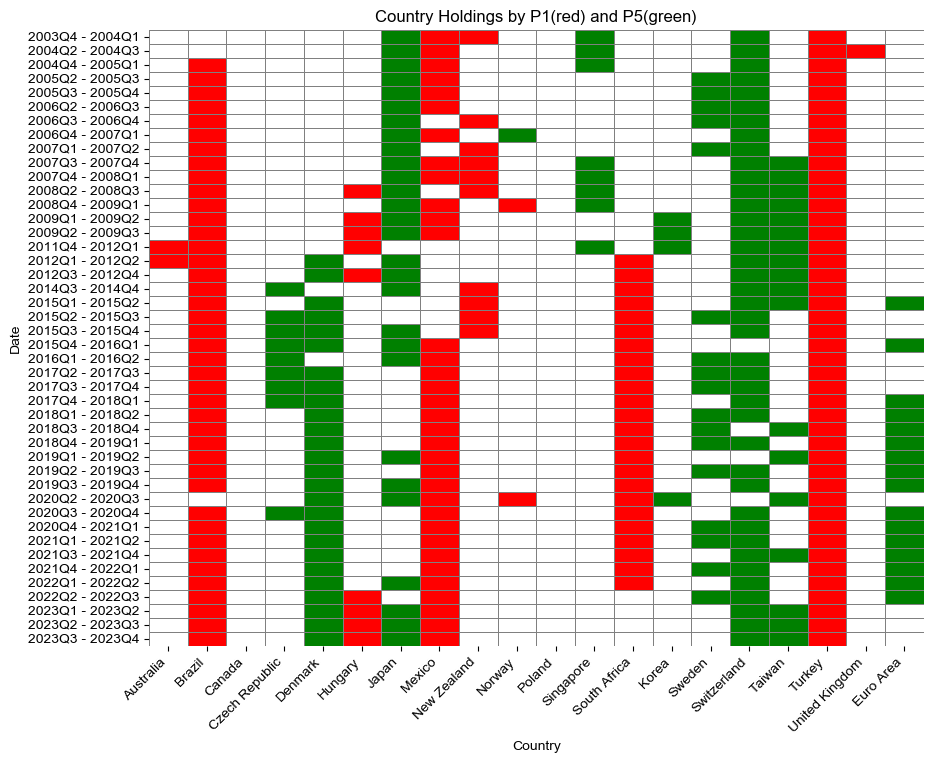

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 修正Boolean索引：生成 test_df 数据
# 使用已修正的significant_dates_all變數，避免Boolean索引警告
valid_rows = rows_below_threshold.reindex(regression_pvalues_df.index, fill_value=False)
significant_dates_heatmap = regression_pvalues_df[valid_rows].index

test_df1 = total_port_3m_ret[f'total_port1'].loc[significant_dates_heatmap].iloc[:, :-1].astype(float)
test_df2 = total_port_3m_ret[f'total_port5'].loc[significant_dates_heatmap].iloc[:, :-1].astype(float)

# 将索引转换为指定的季度格式
def convert_to_quarter(index):
    new_index = []
    for date in index:
        if date.month == 3:
            new_label = f'{date.year}Q2 - {date.year}Q3'
        elif date.month == 6:
            new_label = f'{date.year}Q3 - {date.year}Q4'
        elif date.month == 9:
            new_label = f'{date.year}Q4 - {date.year + 1}Q1'
        elif date.month == 12:
            new_label = f'{date.year + 1}Q1 - {date.year + 1}Q2'
        new_index.append(new_label)
    return new_index

# 应用转换函数
test_df1.index = convert_to_quarter(test_df1.index)
test_df2.index = convert_to_quarter(test_df2.index)

# 绘制第一层红色热力图
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(test_df1, cmap=sns.color_palette(["red"]), cbar=False, xticklabels=True, yticklabels=True, linewidths=0.5, linecolor='grey', ax=ax)

# 叠加绿色热力图，只显示绿色的数据点
sns.heatmap(test_df2, cmap=sns.color_palette(["green"]), cbar=False, xticklabels=True, yticklabels=True, linewidths=0.5, linecolor='grey', ax=ax)

# 设置标题和标签
ax.set_title("Country Holdings by P1(red) and P5(green)")
ax.set_xlabel("Country")
ax.set_ylabel("Date")

# 设置底部的横坐标
ax.set_xticks(ax.get_xticks())  
ax.set_xticklabels(test_df1.columns, rotation=45, ha='right')

# 仅添加减少的垂直线
for spine in ax.spines.values():
    spine.set_visible(False)

# 手动添加灰色垂直线，每隔一定间隔添加一条
for i in range(0, len(test_df1.columns), 2):
    ax.axvline(i, linestyle='-', linewidth=0.5, color='grey')

# 保持 y 轴标签水平
plt.yticks(rotation=0)

# 显示图形
plt.show()

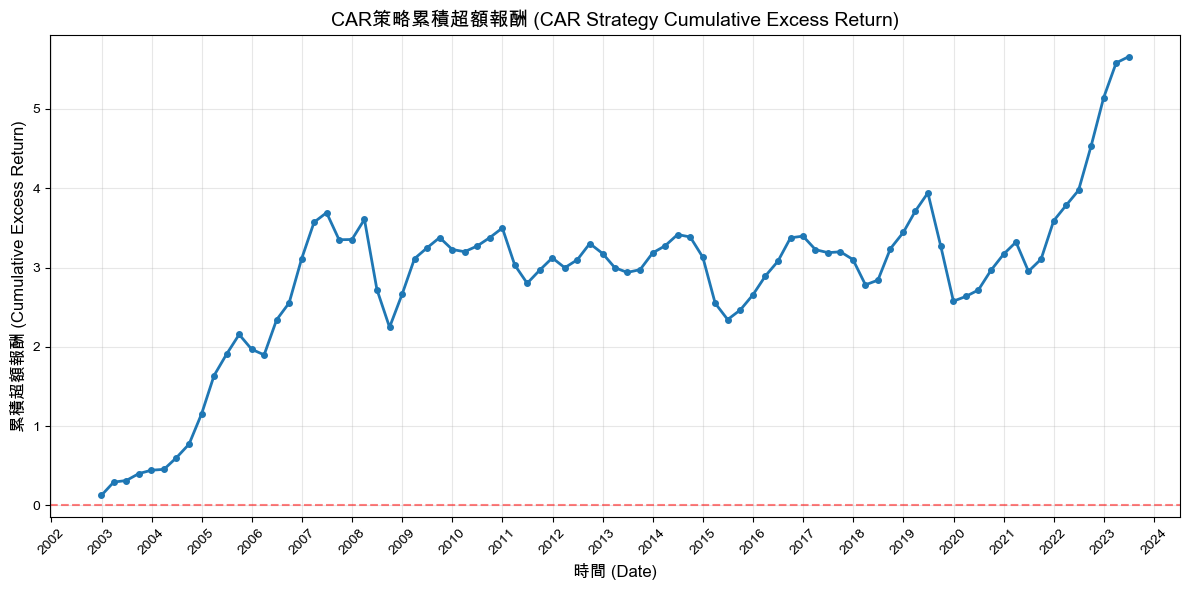

In [61]:
## 5.3 策略績效視覺化

# 繪製累積超額報酬圖
cumulative_returns = (1 + (total_port_3m_ret['total_port1']['Sum_ret'] - total_port_3m_ret['total_port5']['Sum_ret'])).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, marker='o', linestyle='-', linewidth=2, markersize=4)
plt.title(f'{CURRENT_STRATEGY}策略累積超額報酬 ({CURRENT_STRATEGY} Strategy Cumulative Excess Return)', fontsize=14, fontweight='bold')
plt.xlabel('時間 (Date)', fontsize=12)
plt.ylabel('累積超額報酬 (Cumulative Excess Return)', fontsize=12)
plt.grid(True, alpha=0.3)

# 設置日期格式和刻度
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# 添加零線
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 第六部分：匯率報酬分析

## 6.1 純匯率報酬計算（不含利差成分）

In [63]:
holding_period = 2
Excess_ret_2 = (Mid_FX_Q-Mid_FX_Q.shift(holding_period))/Mid_FX_Q.shift(holding_period)
Excess_ret_2 = Excess_ret_2.shift(-holding_period)
# Excess_ret_2.dropna(inplace=True)
total_rank_in_5_shifted = total_rank_in_5.shift(1, axis=1)
total_port_3m_2 = {}
for port in range(1,6):
    FX_position = pd.DataFrame(columns=Excess_ret_2.columns, index=Excess_ret_2.index)
    for dt in total_rank_in_5_shifted.columns:
        cur = list(total_rank_in_5_shifted[total_rank_in_5_shifted.loc[:,dt]==port].index)
        weight = 1/len(cur) if cur else 0
        FX_position.loc[dt,cur] = weight
    FX_position.dropna(how='all', inplace=True)
    total_port_3m_2[f'total_port{port}'] = FX_position


total_port_3m_ret_2 = {}
for key, df in total_port_3m_2.items():
    ret = Excess_ret_2 * df
    ret.dropna(how='all', inplace=True)
    ret['Sum_ret'] = ret.sum(axis=1)
    total_port_3m_ret_2[key] = ret

# 看看08年之後的表現
Excess_ret_2_after2008 = Excess_ret_2.loc[Excess_ret_2.index>pd.to_datetime('2008-01-01')]
total_port_3m_ret_2_after2008 = {}
for key, df in total_port_3m_2.items():
    ret = Excess_ret_2_after2008 * df
    ret.dropna(how='all', inplace=True)
    ret['Sum_ret'] = ret.sum(axis=1)
    total_port_3m_ret_2_after2008[key] = ret

In [64]:
summary_index = ('Mean', 'St. dev.', 'Skew', 'Kurt', 'SR', 'AC', 'Freq')
summary_columns = ('P1', 'P2', 'P3', 'P4', 'P5', 'P1-P5')

summary_2 = pd.DataFrame(index=summary_index, columns=summary_columns)
for port in range(1,7):
    if port<=5:
        ret = total_port_3m_ret_2[f'total_port{port}']['Sum_ret']*100 #乘以100會影響mean和st.dev. 這樣顯示的結果為報酬率%數
        col_name = f'P{port}'
        #這邊先計算freq
        port_df = total_port_3m_ret_2[f'total_port{port}']
        # 初始化列表存储变化比例
        changes = []
        # 计算变化比例
        for i in range(1, len(port_df)):
            prev_positions = set(port_df.iloc[i - 1].dropna().index)
            curr_positions = set(port_df.iloc[i].dropna().index)
            intersection = prev_positions.intersection(curr_positions)
            change_ratio = 1-(len(intersection) / len(prev_positions))
            changes.append(change_ratio)
    else:
        ret = (total_port_3m_ret_2[f'total_port1']['Sum_ret']-total_port_3m_ret_2[f'total_port5']['Sum_ret'])*100
        col_name = summary_columns[-1]
    
    mutilpier = 4/holding_period
    summary_2.loc['Mean',col_name] = ret.mean()*mutilpier  #年化，顯示為年化報酬率
    summary_2.loc['St. dev.',col_name] = ret.std()*np.sqrt(mutilpier) #年化，顯示為年化報酬率標準差
    summary_2.loc['Skew',col_name] = ret.skew()
    summary_2.loc['Kurt',col_name] = ret.kurt()
    summary_2.loc['SR',col_name] = (ret.mean()*mutilpier)/(ret.std()*np.sqrt(mutilpier)) #年化
    summary_2.loc['AC',col_name] = ret.autocorr()
    summary_2.loc['Freq',col_name] = np.mean(changes)

In [65]:
summary_index = ('Mean', 'St. dev.', 'Skew', 'Kurt', 'SR', 'AC', 'Freq')
summary_columns = ('P1', 'P2', 'P3', 'P4', 'P5', 'P1-P5')

summary_2_after2008 = pd.DataFrame(index=summary_index, columns=summary_columns)
for port in range(1,7):
    if port<=5:
        ret = total_port_3m_ret_2_after2008[f'total_port{port}']['Sum_ret']*100 #乘以100會影響mean和st.dev. 這樣顯示的結果為報酬率%數
        col_name = f'P{port}'
        #這邊先計算freq
        port_df = total_port_3m_ret_2_after2008[f'total_port{port}']
        # 初始化列表存储变化比例
        changes = []
        # 计算变化比例
        for i in range(1, len(port_df)):
            prev_positions = set(port_df.iloc[i - 1].dropna().index)
            curr_positions = set(port_df.iloc[i].dropna().index)
            intersection = prev_positions.intersection(curr_positions)
            change_ratio = 1-(len(intersection) / len(prev_positions))
            changes.append(change_ratio)
    else:
        ret = (total_port_3m_ret_2_after2008[f'total_port1']['Sum_ret']-total_port_3m_ret_2_after2008[f'total_port5']['Sum_ret'])*100
        col_name = summary_columns[-1]
    
    mutilpier = 4/holding_period
    summary_2_after2008.loc['Mean',col_name] = ret.mean()*mutilpier  #年化，顯示為年化報酬率
    summary_2_after2008.loc['St. dev.',col_name] = ret.std()*np.sqrt(mutilpier) #年化，顯示為年化報酬率標準差
    summary_2_after2008.loc['Skew',col_name] = ret.skew()
    summary_2_after2008.loc['Kurt',col_name] = ret.kurt()
    summary_2_after2008.loc['SR',col_name] = (ret.mean()*mutilpier)/(ret.std()*np.sqrt(mutilpier)) #年化
    summary_2_after2008.loc['AC',col_name] = ret.autocorr()
    summary_2_after2008.loc['Freq',col_name] = np.mean(changes)

In [66]:
summary_2

,P1,P2,P3,P4,P5,P1-P5
Mean,-3.575152,0.246918,0.032794,0.429464,1.039881,-4.615034
St. dev.,11.458405,11.458732,9.222241,8.49358,7.159797,10.171165
Skew,-0.449242,-0.206203,-0.66417,-0.225081,0.056656,-0.498995
Kurt,0.107952,1.421241,1.103167,0.06239,-0.199666,1.064931
SR,-0.312011,0.021548,0.003556,0.050563,0.145239,-0.453737
AC,0.455415,0.440281,0.503253,0.486508,0.40959,0.394853
Freq,0.07439,0.243089,0.31565,0.304268,0.161585,0.161585


In [67]:
summary_2_after2008

,P1,P2,P3,P4,P5,P1-P5
Mean,-7.245114,-2.451554,-2.906371,-1.73501,-0.036836,-7.208278
St. dev.,11.503195,11.578973,9.213305,8.241888,7.033024,9.39019
Skew,-0.229697,-0.106962,-0.56264,-0.197784,0.169251,-1.105637
Kurt,0.191759,1.979146,1.214263,0.198734,0.04049,1.169123
SR,-0.629835,-0.211725,-0.315454,-0.210511,-0.005238,-0.767639
AC,0.386031,0.440143,0.479958,0.468279,0.406865,0.312807
Freq,0.068852,0.251639,0.320492,0.331148,0.196721,0.196721


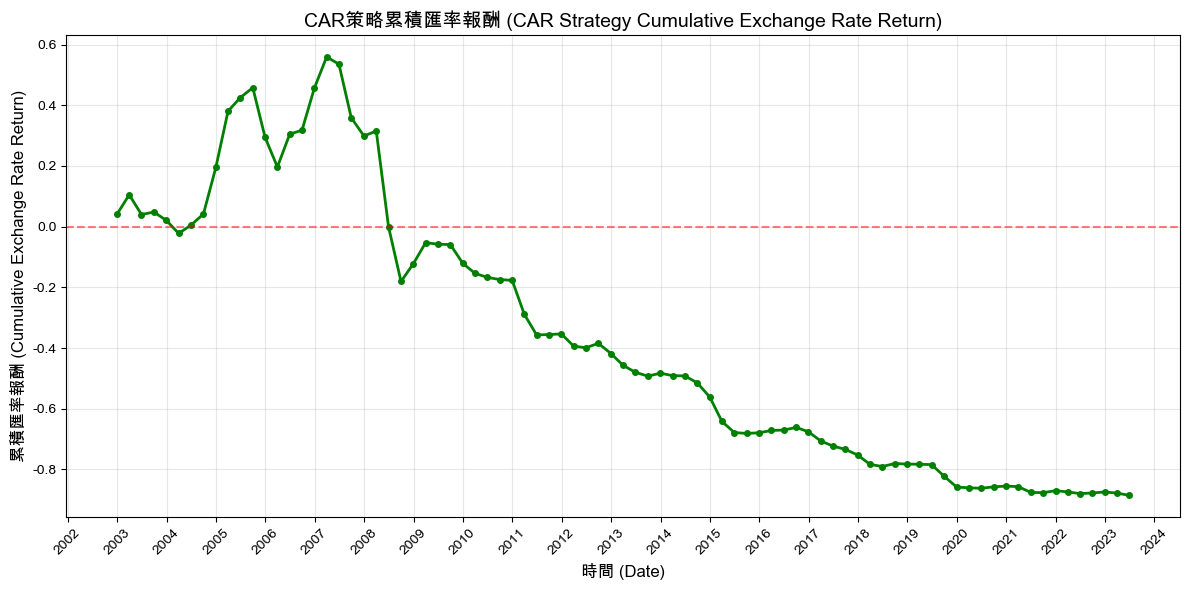

In [68]:
# 繪製累積匯率報酬圖
cumulative_returns_fx = (1 + (total_port_3m_ret_2['total_port1']['Sum_ret'] - total_port_3m_ret_2['total_port5']['Sum_ret'])).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_fx, marker='o', linestyle='-', linewidth=2, markersize=4, color='green')
plt.title(f'{CURRENT_STRATEGY}策略累積匯率報酬 ({CURRENT_STRATEGY} Strategy Cumulative Exchange Rate Return)', fontsize=14, fontweight='bold')
plt.xlabel('時間 (Date)', fontsize=12)
plt.ylabel('累積匯率報酬 (Cumulative Exchange Rate Return)', fontsize=12)
plt.grid(True, alpha=0.3)

# 設置日期格式和刻度
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# 添加零線
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [69]:
# 📊 匯率報酬顯著性p值篩選後的績效分析（2008年後）

summary_index = ('Mean', 'St. dev.', 'Skew', 'Kurt', 'SR', 'AC', 'Freq')
summary_columns = ('P1', 'P2', 'P3', 'P4', 'P5', 'P1-P5')

summary_for_pvalue_under10_2_after2008 = pd.DataFrame(index=summary_index, columns=summary_columns)

# ✅ 修正Boolean索引問題：確保索引對齊
valid_rows_fx_after2008 = rows_below_threshold.reindex(reg_pvalue_after2008.index, fill_value=False)
significant_dates_fx_after2008 = reg_pvalue_after2008[valid_rows_fx_after2008].index

print(f"📈 匯率報酬分析（2008年後）找到 {len(significant_dates_fx_after2008)} 個顯著期間")

for port in range(1,7):
    if port<=5:
        # ✅ 使用索引交集，避免迭代修改
        # 注意：這裡用total_port_3m_ret檢查索引存在性，但用total_port_3m_ret_2計算報酬
        valid_dates = significant_dates_fx_after2008.intersection(
            total_port_3m_ret[f'total_port{port}'].index
        ).intersection(
            total_port_3m_ret_2[f'total_port{port}'].index
        )
        
        if len(valid_dates) == 0:
            print(f"⚠️ 警告：匯率投資組合P{port}（2008年後）沒有有效數據")
            continue
            
        ret = total_port_3m_ret_2[f'total_port{port}'].loc[valid_dates]['Sum_ret']*100
        col_name = f'P{port}'
        
        # 計算投資組合轉換頻率
        port_df = total_port_3m_2[f'total_port{port}'].loc[valid_dates]
        changes = []
        for i in range(1, len(port_df)):
            prev_positions = set(port_df.iloc[i - 1].dropna().index)
            curr_positions = set(port_df.iloc[i].dropna().index)
            if len(prev_positions) > 0:  # 避免除零錯誤
                intersection = prev_positions.intersection(curr_positions)
                change_ratio = 1-(len(intersection) / len(prev_positions))
                changes.append(change_ratio)
    else:
        # P1-P5差額計算，確保所有相關數據都存在
        valid_dates = significant_dates_fx_after2008.intersection(
            total_port_3m_ret[f'total_port1'].index
        ).intersection(
            total_port_3m_ret[f'total_port5'].index
        ).intersection(
            total_port_3m_ret_2[f'total_port1'].index
        ).intersection(
            total_port_3m_ret_2[f'total_port5'].index
        )
        
        if len(valid_dates) == 0:
            print(f"⚠️ 警告：匯率P1-P5差額（2008年後）沒有有效數據")
            continue
            
        ret = (total_port_3m_ret_2[f'total_port1'].loc[valid_dates]['Sum_ret'] - 
               total_port_3m_ret_2[f'total_port5'].loc[valid_dates]['Sum_ret']) * 100
        col_name = summary_columns[-1]
    
    # 數據有效性檢查
    if len(ret) == 0 or ret.isna().all():
        print(f"⚠️ 警告：{col_name}沒有有效的匯率報酬數據（2008年後）")
        continue
    
    # 計算統計指標
    mutilpier = 4/holding_period
    summary_for_pvalue_under10_2_after2008.loc['Mean',col_name] = ret.mean()*mutilpier
    summary_for_pvalue_under10_2_after2008.loc['St. dev.',col_name] = ret.std()*np.sqrt(mutilpier)
    summary_for_pvalue_under10_2_after2008.loc['Skew',col_name] = ret.skew()
    summary_for_pvalue_under10_2_after2008.loc['Kurt',col_name] = ret.kurt()
    summary_for_pvalue_under10_2_after2008.loc['SR',col_name] = (ret.mean()*mutilpier)/(ret.std()*np.sqrt(mutilpier))
    summary_for_pvalue_under10_2_after2008.loc['AC',col_name] = ret.autocorr()
    
    # 安全處理changes計算
    if port <= 5 and len(changes) > 0:
        summary_for_pvalue_under10_2_after2008.loc['Freq',col_name] = np.mean(changes)
    elif port <= 5:
        summary_for_pvalue_under10_2_after2008.loc['Freq',col_name] = np.nan

📈 匯率報酬分析（2008年後）找到 33 個顯著期間


In [70]:
# 📊 匯率報酬顯著性p值篩選後的績效分析 

summary_index = ('Mean', 'St. dev.', 'Skew', 'Kurt', 'SR', 'AC', 'Freq')
summary_columns = ('P1', 'P2', 'P3', 'P4', 'P5', 'P1-P5')

summary_for_pvalue_under10_2 = pd.DataFrame(index=summary_index, columns=summary_columns)

# ✅ 修正Boolean索引問題
valid_rows_fx = rows_below_threshold.reindex(regression_pvalues_df.index, fill_value=False)
significant_dates_fx = regression_pvalues_df[valid_rows_fx].index

print(f"📈 匯率報酬分析找到 {len(significant_dates_fx)} 個顯著期間")

for port in range(1,7):
    if port<=5:
        # ✅ 使用索引交集，確保數據存在
        valid_dates = significant_dates_fx.intersection(total_port_3m_ret_2[f'total_port{port}'].index)
        
        if len(valid_dates) == 0:
            print(f"⚠️ 警告：匯率投資組合P{port}沒有有效數據")
            continue
            
        ret = total_port_3m_ret_2[f'total_port{port}'].loc[valid_dates]['Sum_ret']*100
        col_name = f'P{port}'
        
        # 計算投資組合轉換頻率
        port_df = total_port_3m_2[f'total_port{port}'].loc[valid_dates]
        changes = []
        for i in range(1, len(port_df)):
            prev_positions = set(port_df.iloc[i - 1].dropna().index)
            curr_positions = set(port_df.iloc[i].dropna().index)
            if len(prev_positions) > 0:  # 避免除零錯誤
                intersection = prev_positions.intersection(curr_positions)
                change_ratio = 1-(len(intersection) / len(prev_positions))
                changes.append(change_ratio)
    else:
        # P1-P5差額計算
        valid_dates = significant_dates_fx.intersection(
            total_port_3m_ret_2[f'total_port1'].index
        ).intersection(
            total_port_3m_ret_2[f'total_port5'].index
        )
        
        if len(valid_dates) == 0:
            print(f"⚠️ 警告：匯率P1-P5差額沒有有效數據")
            continue
            
        ret = (total_port_3m_ret_2[f'total_port1'].loc[valid_dates]['Sum_ret'] - 
               total_port_3m_ret_2[f'total_port5'].loc[valid_dates]['Sum_ret']) * 100
        col_name = summary_columns[-1]
    
    # 數據有效性檢查
    if len(ret) == 0 or ret.isna().all():
        print(f"⚠️ 警告：{col_name}沒有有效的匯率報酬數據")
        continue
    
    # 計算統計指標
    mutilpier = 4/holding_period
    summary_for_pvalue_under10_2.loc['Mean',col_name] = ret.mean()*mutilpier
    summary_for_pvalue_under10_2.loc['St. dev.',col_name] = ret.std()*np.sqrt(mutilpier)
    summary_for_pvalue_under10_2.loc['Skew',col_name] = ret.skew()
    summary_for_pvalue_under10_2.loc['Kurt',col_name] = ret.kurt()
    summary_for_pvalue_under10_2.loc['SR',col_name] = (ret.mean()*mutilpier)/(ret.std()*np.sqrt(mutilpier))
    summary_for_pvalue_under10_2.loc['AC',col_name] = ret.autocorr()
    
    # 安全處理changes計算
    if port <= 5 and len(changes) > 0:
        summary_for_pvalue_under10_2.loc['Freq',col_name] = np.mean(changes)
    elif port <= 5:
        summary_for_pvalue_under10_2.loc['Freq',col_name] = np.nan

📈 匯率報酬分析找到 44 個顯著期間


In [71]:
summary_for_pvalue_under10_2_after2008

,P1,P2,P3,P4,P5,P1-P5
Mean,-5.817515,-1.475314,-2.421738,-0.851852,-0.816509,-5.001006
St. dev.,11.036735,11.645272,9.060063,8.526071,7.40317,8.913883
Skew,0.100772,0.457937,-0.333135,-0.095521,0.077612,-0.892192
Kurt,0.708348,2.384129,0.695762,0.309363,0.274373,0.800426
SR,-0.527105,-0.126688,-0.267298,-0.099911,-0.110292,-0.561036
AC,0.315488,0.365453,0.378915,0.37112,0.358756,0.123432
Freq,0.085938,0.348958,0.455729,0.479167,0.273438,NaN


In [72]:
summary_for_pvalue_under10_2

,P1,P2,P3,P4,P5,P1-P5
Mean,-2.580491,0.744516,0.041876,0.645067,0.309758,-2.890249
St. dev.,10.932995,10.913881,8.590303,7.836297,7.429427,9.766496
Skew,-0.192897,0.162366,-0.673306,-0.414411,0.072137,-0.301927
Kurt,0.22538,2.066194,0.959407,0.600978,0.16731,0.72684
SR,-0.236028,0.068217,0.004875,0.082318,0.041693,-0.295935
AC,0.344465,0.332499,0.382985,0.318106,0.236974,0.133318
Freq,0.108527,0.375969,0.467054,0.457364,0.234496,NaN


In [74]:
# 整合策略報酬結果並輸出至Excel
total_ret = pd.DataFrame(total_port_3m_ret[f'total_port1']['Sum_ret'] - total_port_3m_ret[f'total_port5']['Sum_ret'])
total_ret.columns = ['excess_return']
total_ret['exchange_rate_return'] = total_port_3m_ret_2[f'total_port1']['Sum_ret'] - total_port_3m_ret_2[f'total_port5']['Sum_ret']

# 對於基於迴歸的策略，添加顯著性變數信息
if CURRENT_STRATEGY in ['RREVI', 'CAR', 'REVI']:
    total_ret['significant_variables'] = rows_below_threshold[3:]
elif CURRENT_STRATEGY == 'VI':
    # VI策略不使用迴歸，所以不需要顯著性變數資訊
    total_ret['strategy_note'] = 'VI_strategy_pure_fundamentals'

# 輸出結果，文件名根據當前策略動態生成
output_filename = f'{CURRENT_STRATEGY}_strategy_results.xlsx'
total_ret.to_excel(output_filename)

print(f"📊 {CURRENT_STRATEGY}策略分析完成 ({CURRENT_STRATEGY} Strategy Analysis Completed)")
print(f"📁 策略結果已儲存至: {output_filename}")
print(f"📁 Strategy results saved to: {output_filename}")

# 顯示策略績效摘要
print(f"\n📈 {CURRENT_STRATEGY}策略績效摘要 (Performance Summary):")
print(f"• 年化超額報酬率: {total_ret['excess_return'].mean() * 100 * 2:.2f}%")
print(f"• 年化匯率報酬率: {total_ret['exchange_rate_return'].mean() * 100 * 2:.2f}%")
print(f"• 報酬波動度: {total_ret['excess_return'].std() * 10 * np.sqrt(2):.2f}%")
print(f"• 夏普比率: {(total_ret['excess_return'].mean() * 2) / (total_ret['excess_return'].std() * np.sqrt(2)):.3f}")

📊 CAR策略分析完成 (CAR Strategy Analysis Completed)
📁 策略結果已儲存至: CAR_strategy_results.xlsx
📁 Strategy results saved to: CAR_strategy_results.xlsx

📈 CAR策略績效摘要 (Performance Summary):
• 年化超額報酬率: 5.22%
• 年化匯率報酬率: -4.62%
• 報酬波動度: 1.10%
• 夏普比率: 0.473
